# Joint data analysis

This will be the notebook in which I will conduct my joint data analysis.
The idea is that I can use my JOD data as well as my quantitative data from the cluster in order to formulate some joint statements about my model performance.

In [6]:
import pandas as pd

df_jod = pd.read_excel("data/jod.xlsx")
df_metrics = pd.read_excel("data/singleMetricsResult.xlsx")

## Objective Ranking

### Lineplots - What is the objective ranking per facet of the data?

In [7]:
from matplotlib import pyplot as plt
import numpy as np


def bootstrap_std(data, n_boot=10000):
    boot_samples = np.random.choice(data, (n_boot, len(data)), replace=True)
    return np.std(boot_samples, axis=1).mean()  # Mean of bootstrapped stds


def contrast_ranking_by_size(dataset: str) -> None:
    fig, axs = plt.subplots(2, 2, figsize=(18, 10))
    handles, labels = [], []

    for i, metric in enumerate(["psnr", "ssim", "lpips", "brisque"]):
        df_constrained = df_metrics[df_metrics["dataset"] == dataset]
        for model in df_constrained["model"].unique():
            if metric == "brisque":
                sub_df = (
                    (
                        df_constrained[df_constrained["model"] == model][
                            [
                                "size",
                                "brisque",
                                "brisque_0",
                                "brisque_1",
                                "brisque_2",
                                "brisque_3",
                                "brisque_4",
                            ]
                        ]
                        .melt(id_vars="size")
                        .rename({"value": "brisque"}, axis=1)
                    )
                    .groupby(["size"], sort=False, as_index=False)[["brisque"]]
                    .agg(["mean", bootstrap_std, "count"])
                )
            else:
                sub_df = (
                    df_constrained[df_constrained["model"] == model]
                    .groupby(["size"], sort=False, as_index=False)[[metric]]
                    .agg(["mean", bootstrap_std, "count"])
                )

            y_vals = sub_df[metric, "mean"]
            ci_1 = (
                sub_df[metric, "bootstrap_std"] / np.sqrt(sub_df[metric, "count"]) * 1
            )

            current_handles = axs[i % 2][int(i / 2)].plot(["low", "medium", "high"], y_vals)

            if i == 0:
                handles.extend(current_handles)
                labels.append(model)

            axs[i % 2][int(i / 2)].fill_between(
                ["low", "medium", "high"],
                y_vals - ci_1,
                y_vals + ci_1,
                alpha=0.6,
                color="#d6d6d6",
            )
            axs[i % 2][int(i / 2)].set_ylabel(metric)

    fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle(f"{dataset} dataset metrics (grey = 1 standard dev)")
    plt.show()


# contrast_ranking_by_size("room")

In [8]:
# contrast_ranking_by_size("stump")

In [9]:
# contrast_ranking_by_size("truck")

### Violinplot - facet by facet ranking

/tmp/ipykernel_8934/4280317499.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_8934/4280317499.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_8934/4280317499.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_8934/4280317499.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_8934/4280317499.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of t

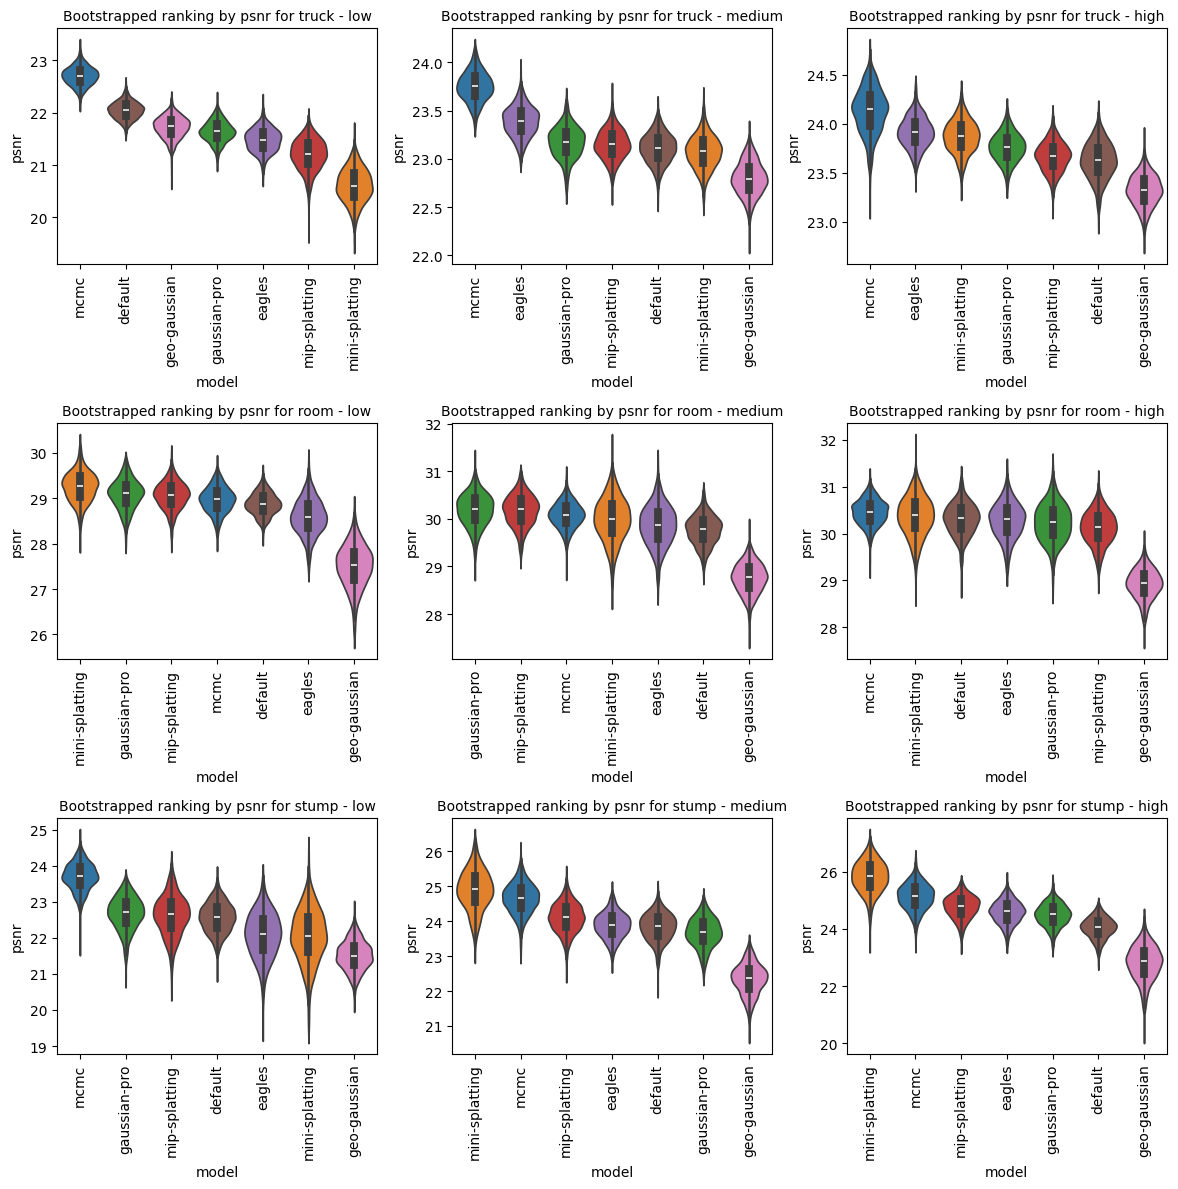

In [10]:
import seaborn as sns


def plot_facet_ranking_as_violin_plot(
    dataset: str, size: str, ax: plt.Axes, metric="psnr"
) -> None:
    subset = df_metrics[
        (df_metrics["dataset"] == dataset) & (df_metrics["size"] == size)
    ]
    boot_samples_idx = np.random.choice(subset.index, (1000, len(subset)), replace=True)

    means = []
    for sample_idx in boot_samples_idx:
        means.append(
            subset.loc[sample_idx].groupby("model")[metric].mean().reset_index()
        )

    means_df = pd.concat(means)
    sns.violinplot(
        means_df,
        x="model",
        y=metric,
        hue_order=[
            "mcmc",
            "mini-splatting",
            "gaussian-pro",
            "mip-splatting",
            "eagles",
            "default",
            "geo-gaussian",
        ],
        hue="model",
        order=means_df.groupby("model")[metric]
        .mean()
        .sort_values(ascending=False)
        .index,
        ax=ax,
    )
    ax.set_title(
        f"Bootstrapped ranking by {metric} for {dataset} - {size}", {"fontsize": 10}
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


fig, axs = plt.subplots(3, 3, figsize=(12, 12))

for i, dataset in enumerate(df_metrics["dataset"].unique()):
    for j, size in enumerate(df_metrics["size"].unique()):
        plot_facet_ranking_as_violin_plot(dataset, size, ax=axs[i][j])
plt.tight_layout()

### Barplot - Difference to the best model in each facet?

In [11]:
def compute_difference_to_peak() -> pd.DataFrame:
    records = []

    for model in df_metrics["model"].unique():
        for size in ["low", "medium", "high"]:
            for dataset in ["room", "stump", "truck"]:
                df_subset_self = df_metrics[
                    (df_metrics["model"] == model)
                    & (df_metrics["size"] == size)
                    & (df_metrics["dataset"] == dataset)
                ][["psnr", "ssim", "lpips"]].mean()
                df_subset_all = (
                    df_metrics[
                        (df_metrics["size"] == size)
                        & (df_metrics["dataset"] == dataset)
                    ]
                    .groupby("model")[["psnr", "ssim", "lpips"]]
                    .mean()
                )
                records.append(
                    {
                        "model": model,
                        "size": size,
                        "dataset": dataset,
                        "diff_to_best_psnr": df_subset_all["psnr"].max()
                        - df_subset_self["psnr"],
                        "diff_to_best_ssim": df_subset_all["ssim"].max()
                        - df_subset_self["ssim"],
                    }
                )

    return pd.DataFrame.from_records(records)

In [12]:
diff_to_max = compute_difference_to_peak()
diff_to_max

,model,size,dataset,diff_to_best_psnr,diff_to_best_ssim
0,default,low,room,0.377824,0.001631
1,default,low,stump,1.167808,0.044589
2,default,low,truck,0.655117,0.004397
3,default,medium,room,0.431082,0.000000
4,default,medium,stump,1.057550,0.049620
...,...,...,...,...,...
58,mip-splatting,medium,stump,0.811184,0.050181
59,mip-splatting,medium,truck,0.602610,0.004792
60,mip-splatting,high,room,0.336381,0.003934
61,mip-splatting,high,stump,1.039185,0.050072


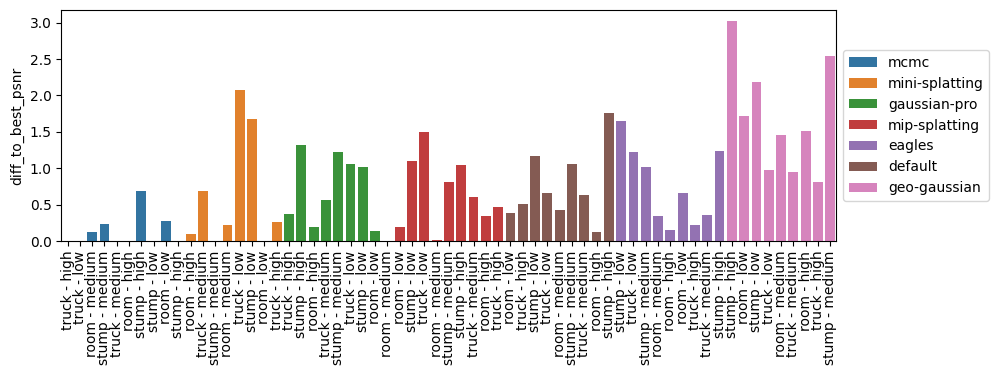

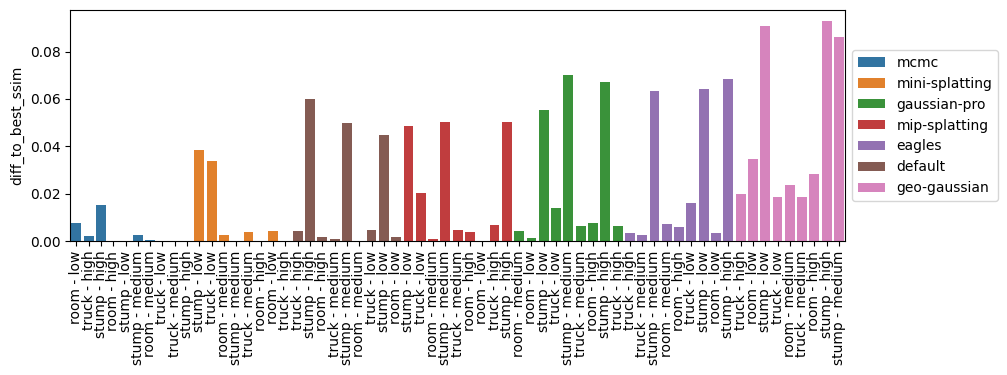

In [13]:
import seaborn as sns


def visualize_diff_to_max(
    df_diff_to_max: pd.DataFrame, var="diff_to_best_psnr", show_ticks=True
):
    df_sorted = df_diff_to_max
    order = df_diff_to_max.groupby("model")[var].sum().sort_values()
    df_sorted["total"] = df_diff_to_max["model"].apply(lambda x: order[x])
    df_sorted = df_sorted.sort_values("total").reset_index()
    fig = plt.figure(figsize=(10, 3))
    sns.barplot(
        data=df_sorted,
        x=df_sorted.index,
        y=var,
        hue="model",
        dodge=False,
        hue_order=[
            "mcmc",
            "mini-splatting",
            "gaussian-pro",
            "mip-splatting",
            "eagles",
            "default",
            "geo-gaussian",
        ],
    )
    if show_ticks:
        plt.xticks(
            ticks=range(len(df_sorted)),
            labels=df_sorted[["model", "dataset", "size"]]
            .apply(tuple, axis=1)
            .apply(lambda x: f"{x[1]} - {x[2]}"),
            rotation=90,
        )
    else:
        plt.xticks(
            ticks=range(len(df_sorted)),
            labels=["" for _ in range(len(df_sorted))],
        )
    plt.xlabel("")
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()


visualize_diff_to_max(diff_to_max)
visualize_diff_to_max(diff_to_max, "diff_to_best_ssim")

### Violinplot - Global score / Borda count

In [14]:
import seaborn as sns


def bootstrap_df(df: pd.DataFrame, n_samples=100):
    for i in range(n_samples):
        yield df.sample(frac=1, replace=True, random_state=i)


def compute_ranking_global_bootstrap(ax: plt.Axes, metric="psnr") -> None:
    df_rankings = None

    for dataset in ["room", "stump", "truck"]:
        for size in ["low", "medium", "high"]:
            df = df_metrics[
                (df_metrics["dataset"] == dataset) & (df_metrics["size"] == size)
            ]
            rankings = []
            for i, df_bootstrap in enumerate(bootstrap_df(df[["model", metric]], 100)):
                mean_psnr = df_bootstrap.groupby("model")[metric].mean()
                rankings.append(mean_psnr.rank(method="min", ascending=True).values)
            df_rankings_new = pd.DataFrame(rankings, columns=df["model"].unique())
            df_rankings_new["bs_index"] = list(range(100))
            if df_rankings is None:
                df_rankings = df_rankings_new
            else:
                df_rankings = pd.concat([df_rankings, df_rankings_new])

    df_borda = df_rankings.groupby("bs_index").sum()
    sns.violinplot(
        df_borda.melt(),
        x="variable",
        y="value",
        hue="variable",
        order=df_borda.mean().sort_values(ascending=False).index,
        hue_order=[
            "mcmc",
            "mini-splatting",
            "gaussian-pro",
            "mip-splatting",
            "eagles",
            "default",
            "geo-gaussian",
        ],
        ax=ax,
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_ylabel(metric)
    ax.set_xlabel("technique")
    ax.set_title(f"Global Borda-Count Ranking ({metric})")

/tmp/ipykernel_8934/2775294084.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_8934/2775294084.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
/tmp/ipykernel_8934/2775294084.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


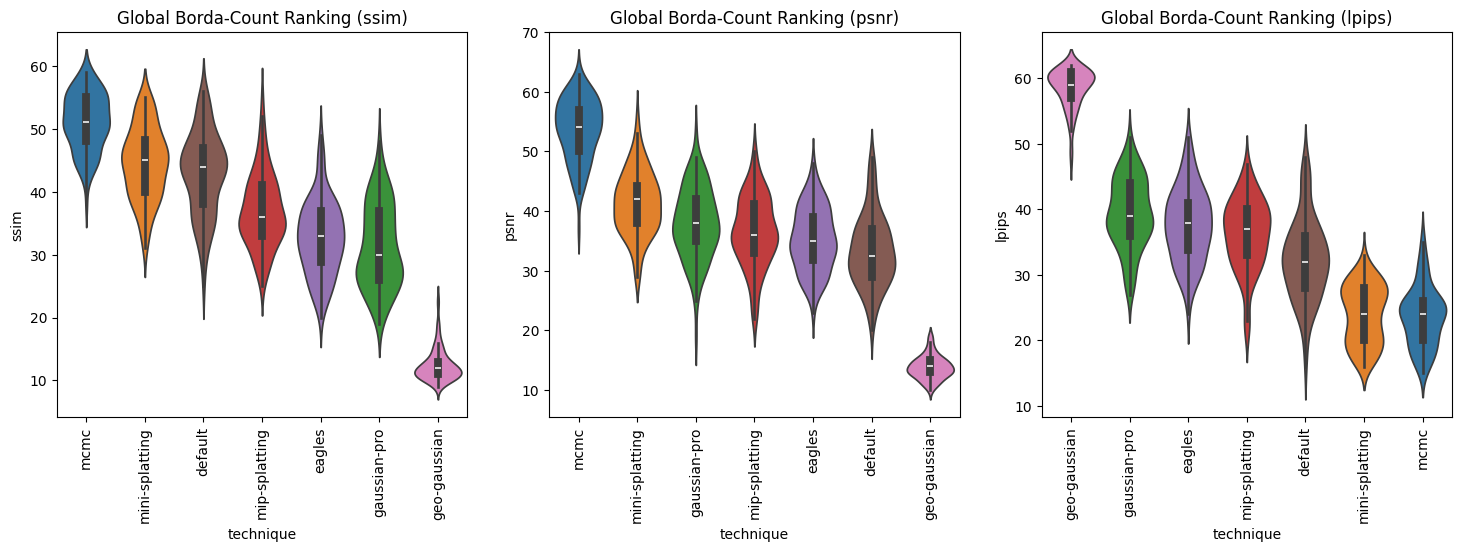

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(["ssim", "psnr", "lpips"]):
    compute_ranking_global_bootstrap(axs[i], metric=metric)

### Kendalls W

In [16]:
objective_kendall_ssim = df_metrics.groupby(["model", "dataset", "size"])["ssim"].mean().unstack(level=0)
objective_kendall_psnr = df_metrics.groupby(["model", "dataset", "size"])["psnr"].mean().unstack(level=0)

def compute_kendall(data: pd.DataFrame) -> float:
    ranked_data = data.rank(axis=1)

    m, n = ranked_data.shape

    R_i = ranked_data.sum(axis=0)
    S = ((R_i - R_i.mean()) ** 2).sum()

    return 12 * S / (m**2 * (n**3 - n))

print(f"Kendall's W (SSIM): {compute_kendall(objective_kendall_ssim):.4f}")
print(f"Kendall's W (PSNR): {compute_kendall(objective_kendall_psnr):.4f}")

Kendall's W (SSIM): 0.5450
Kendall's W (PSNR): 0.4444


In [17]:
import pingouin as pg

pg.friedman(objective_kendall_ssim)

,Source,W,ddof1,Q,p-unc
Friedman,Within,0.544974,6,29.428571,0.00005


### PCA

#### PCA on methods

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def pca_project_methods(ax: plt.Axes, metric="ssim") -> None:
    data = (
        df_metrics.groupby(["model", "dataset", "size"])[metric].mean().unstack(level=0)
    )

    # Standardize the data (important for PCA)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.transpose())

    # Apply PCA
    pca = PCA(n_components=2)  # Keep all components
    pca.fit(data_scaled)

    data_pca = pca.transform(data_scaled)

    ax.scatter(data_pca[:, 0], data_pca[:, 1], c="b", edgecolors="k")
    for i, method in enumerate(data.columns):
        ax.annotate(method, (data_pca[i, 0] + 0.05, data_pca[i, 1] + 0.05))
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"PCA Projection of Methods ({metric})")
    ax.grid()

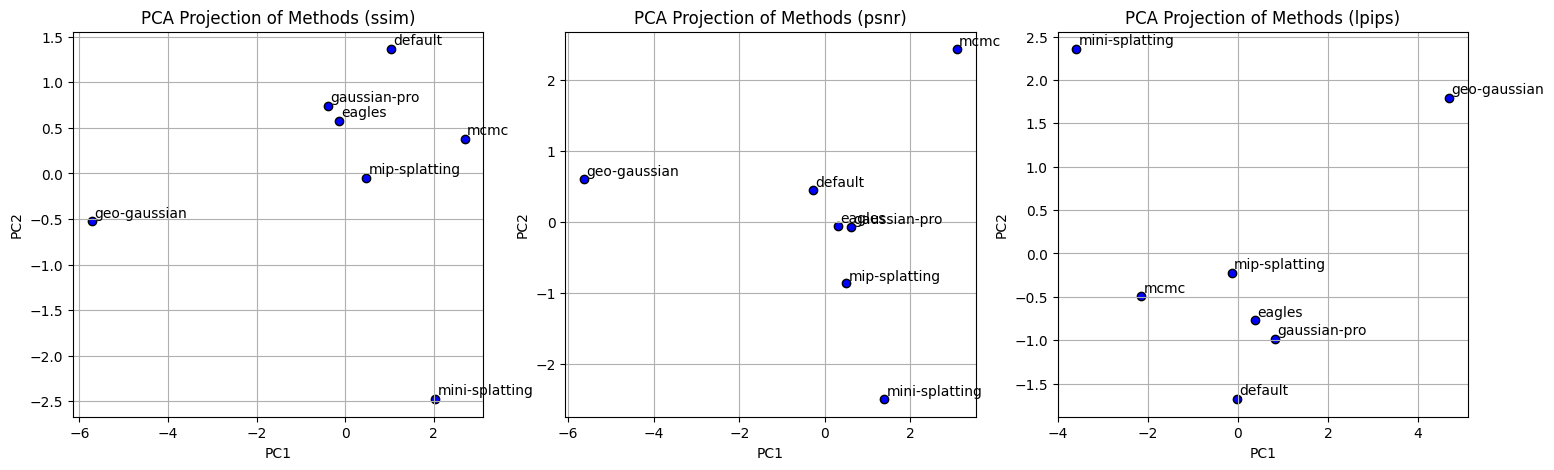

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(["ssim", "psnr", "lpips"]):
    pca_project_methods(axs[i], metric=metric)

#### PCA on facets

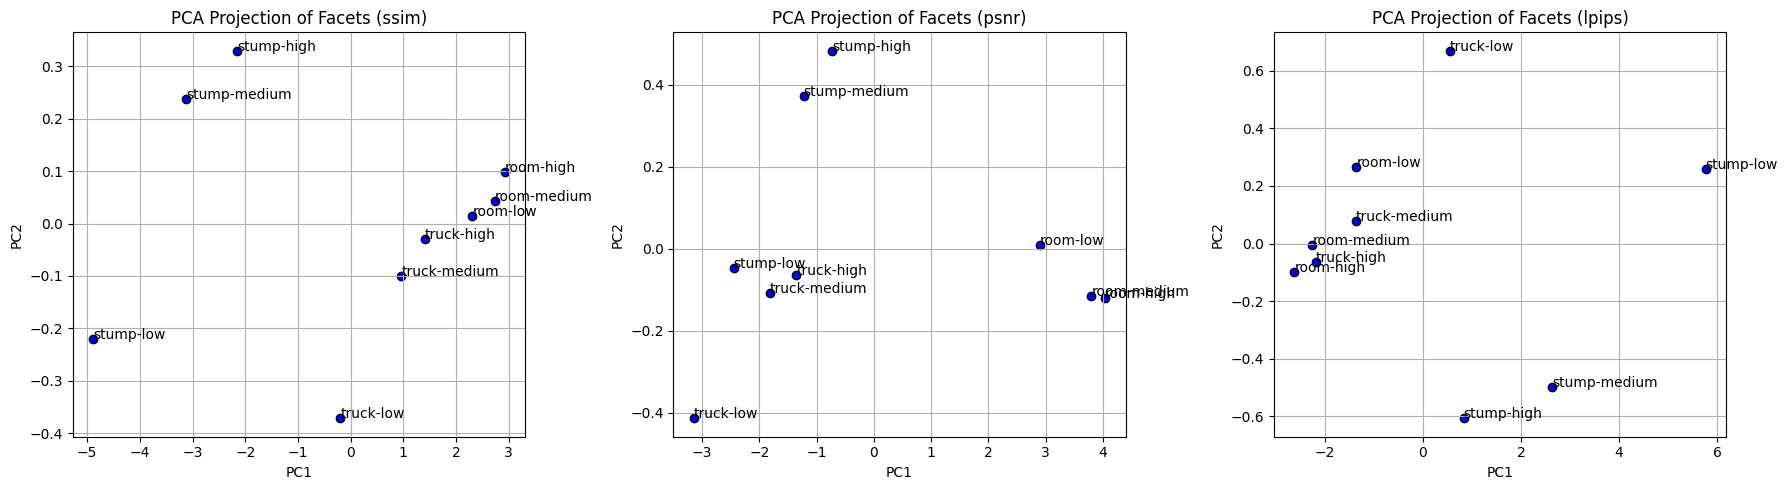

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def pca_project_facets(ax: plt.Axes, metric="ssim") -> None:
    data = (
        df_metrics.groupby(["model", "dataset", "size"])[metric].mean().unstack(level=0)
    )

    # Standardize the data (important for PCA)
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Apply PCA
    pca = PCA(n_components=2)  # Keep all components
    pca.fit(data_scaled)

    data_pca = pca.transform(data_scaled)

    ax.scatter(data_pca[:, 0], data_pca[:, 1], c="b", edgecolors="k")
    for i, facet in enumerate([f"{x[0]}-{x[1]}" for x in data.index.values]):
        ax.annotate(facet, (data_pca[i, 0], data_pca[i, 1]))
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"PCA Projection of Facets ({metric})")
    ax.grid()

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

for i, metric in enumerate(["ssim", "psnr", "lpips"]):
    pca_project_facets(ax[i], metric=metric)
plt.tight_layout()

## Subjective Ranking

In [21]:
df_jod_cv_20 = pd.read_excel("data/jod_k_fold_20.xlsx")
df_jod_cv_20

,Unnamed: 0,size,dataset,fold_idx,default,mcmc,mini_splatting,eagles,mip_splatting,gaussian_pro,geo_gaussian
0,0,low,room,0,1.889599,-0.641652,-0.747568,-0.384492,1.225611,-0.598738,-0.742762
1,1,low,room,1,6.410905,-0.724706,-1.700299,-1.280626,-0.279626,-1.016188,-1.409475
2,2,low,room,2,1.692514,-0.041335,-0.633308,-0.540559,0.658998,-0.445071,-0.691242
3,3,low,room,3,1.681915,-0.237478,-0.644640,-0.559102,0.751033,-0.312601,-0.679129
4,4,low,room,4,1.652473,-0.229456,-0.643158,-0.547514,0.670736,-0.313977,-0.589104
...,...,...,...,...,...,...,...,...,...,...,...
175,175,high,truck,15,-0.536126,-0.902467,-0.505849,2.041196,0.843753,1.029916,-1.970423
176,176,high,truck,16,-0.536126,-0.902467,-0.505849,2.041196,0.843753,1.029916,-1.970423
177,177,high,truck,17,-0.527973,-0.672681,-0.620896,2.020922,0.825211,1.014218,-2.038803
178,178,high,truck,18,-0.679229,-0.895150,-0.426064,2.047629,0.868893,1.044147,-1.960229


### Violinplot - Global Score by Borda Count

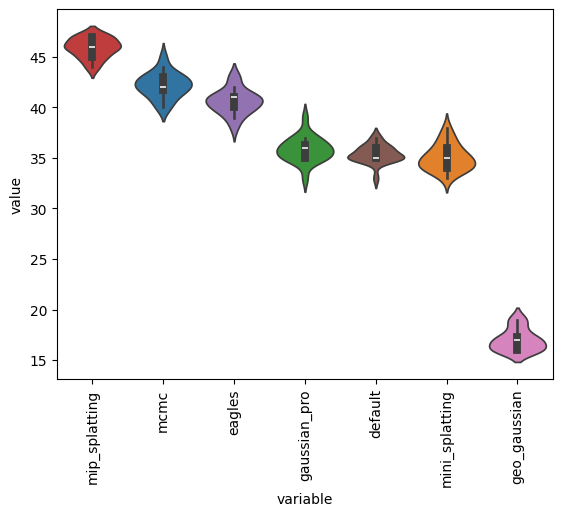

In [22]:
records = []
for idx, row in df_jod_cv_20.iterrows():
    ranks = (
        row[
            [
                "default",
                "mcmc",
                "mini_splatting",
                "eagles",
                "mip_splatting",
                "gaussian_pro",
                "geo_gaussian",
            ]
        ]
        .rank(method="min", ascending=True)
        .to_dict()
    )
    records.append(
        {
            "fold_idx": row["fold_idx"],
            **ranks,
        }
    )


df_borda = pd.DataFrame.from_records(records).groupby("fold_idx").sum()
df_borda
sns.violinplot(
    df_borda.melt(),
    x="variable",
    y="value",
    hue="variable",
    order=df_borda.mean().sort_values(ascending=False).index,
    hue_order=[
        "mcmc",
        "mini_splatting",
        "gaussian_pro",
        "mip_splatting",
        "eagles",
        "default",
        "geo_gaussian",
    ],
)
plt.xticks(rotation=90)
plt.show()

### Violinplot - facet by facet

In [61]:
def plot_facet_by_facet_jod_ranking(dataset: str, size: str, ax: plt.Axes) -> None:
    df_subset = df_jod_cv_20[
        (df_jod_cv_20["dataset"] == dataset) & (df_jod_cv_20["size"] == size)
    ]

    df_subset = df_subset[
        [
            "default",
            "mcmc",
            "mini_splatting",
            "eagles",
            "mip_splatting",
            "gaussian_pro",
            "geo_gaussian",
        ]
    ]
    df_subset.melt()

    sns.violinplot(
        df_subset.melt(),
        x="variable",
        y="value",
        hue="variable",
        order=df_subset.mean().sort_values(ascending=False).index,
        hue_order=[
            "mcmc",
            "mini_splatting",
            "gaussian_pro",
            "mip_splatting",
            "eagles",
            "default",
            "geo_gaussian",
        ],
        ax=ax
    )
    ax.tick_params(labelrotation=90)
    ax.set_title(f"Ranking by JOD - {dataset}-{size}")
    ax.set_xlabel("Method")
    ax.set_ylabel("JOD")

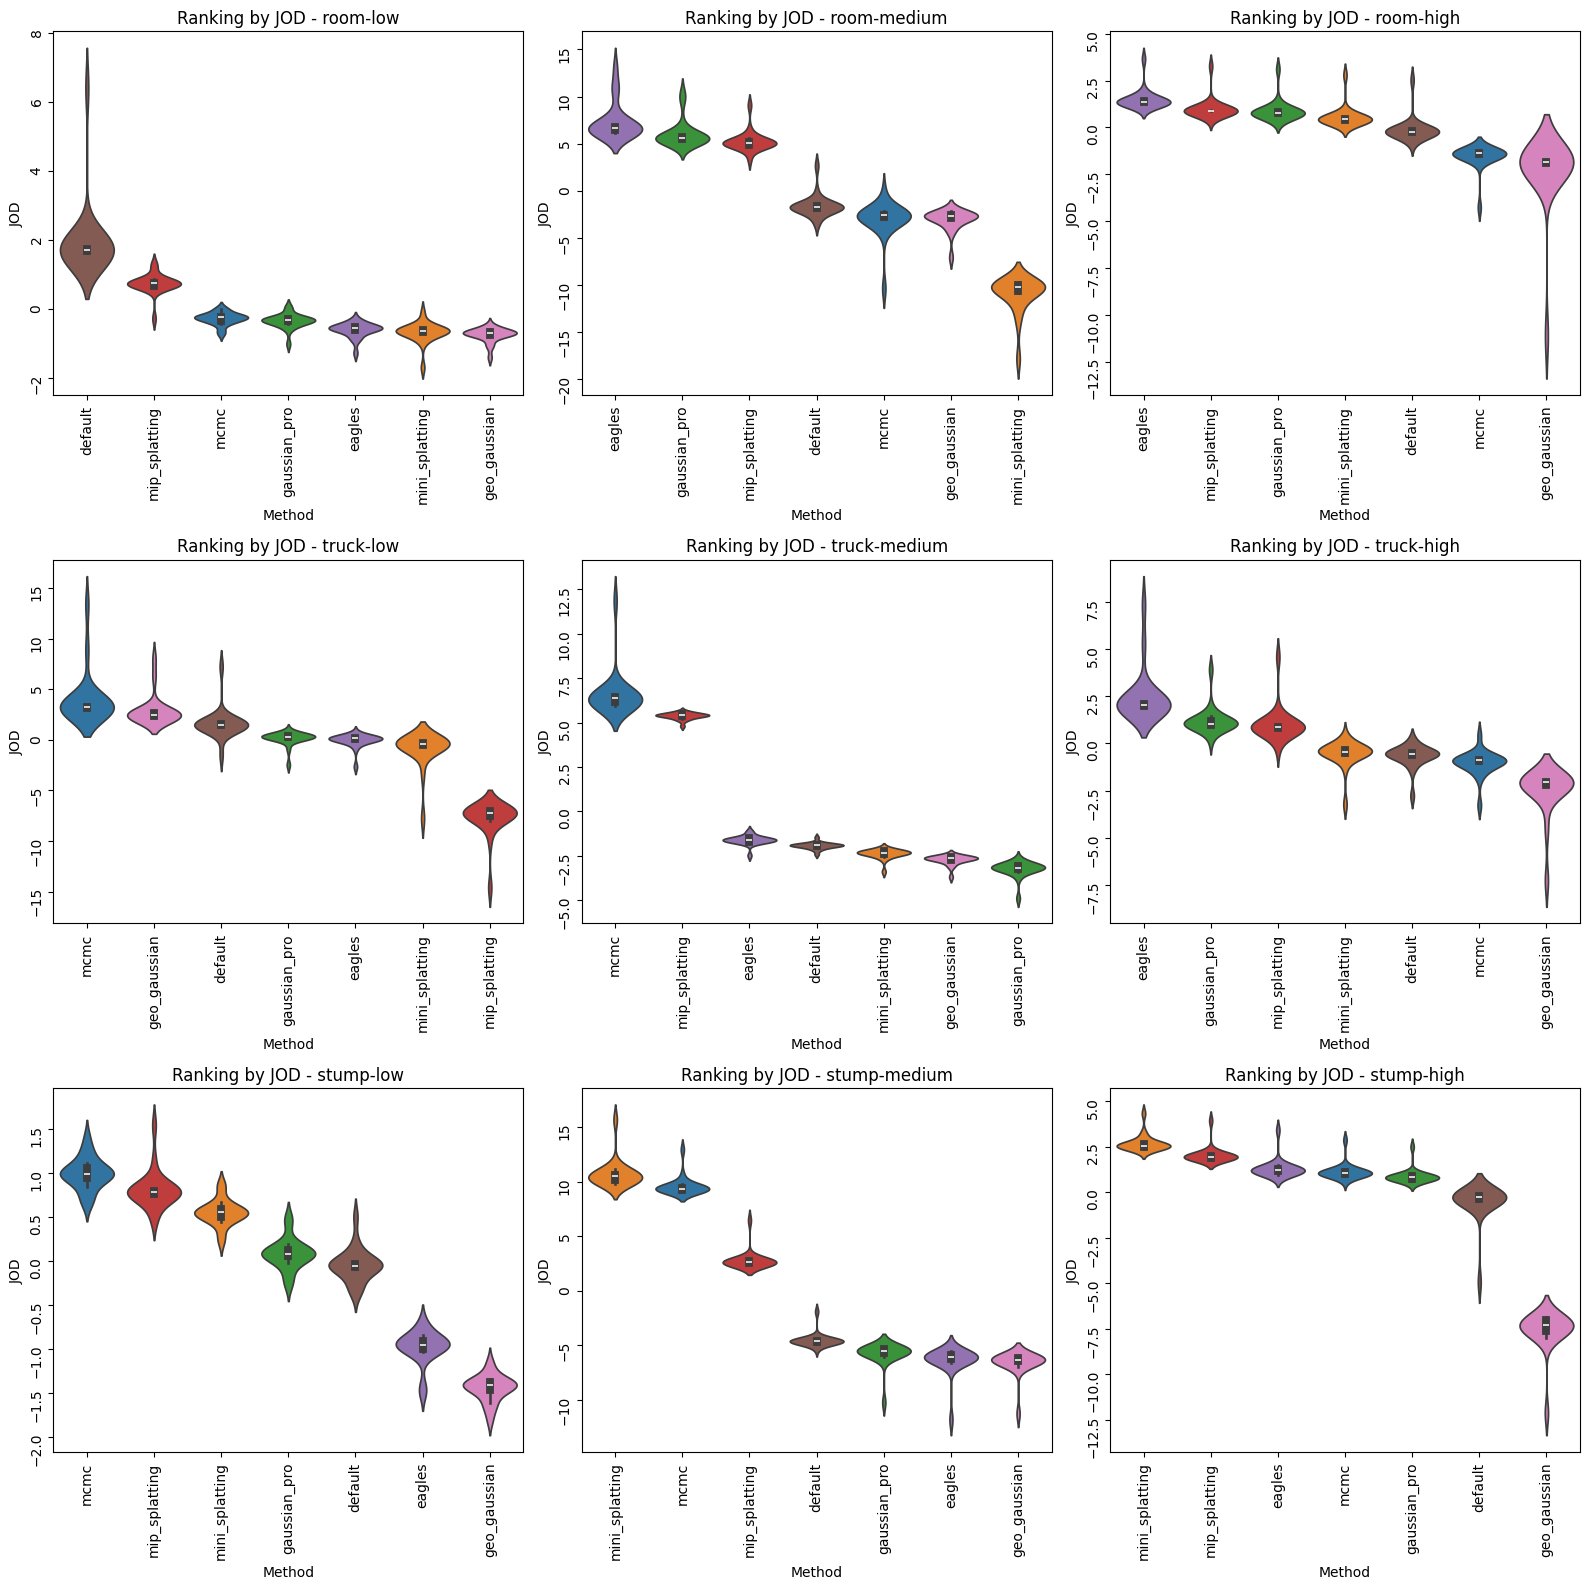

In [66]:
fig, axs = plt.subplots(3, 3, figsize=(16, 16))
for i, dataset in enumerate(["room", "truck", "stump"]):
    for j, size in enumerate(["low", "medium", "high"]):
        plot_facet_by_facet_jod_ranking(dataset, size, axs[i][j])
plt.tight_layout()
plt.show()

### Kendalls W

In [24]:
kendalls = [
    compute_kendall(df_jod_cv_20[df_jod_cv_20["fold_idx"] == fold_idx].iloc[:, 4:])
    for fold_idx in df_jod_cv_20["fold_idx"].unique()
]
print(f"Kendalls W {np.mean(kendalls):.4f} +- {np.std(kendalls) * 1.96:.4f} ci")

Kendalls W 0.2330 +- 0.0421 ci


(0.0, 1.0)

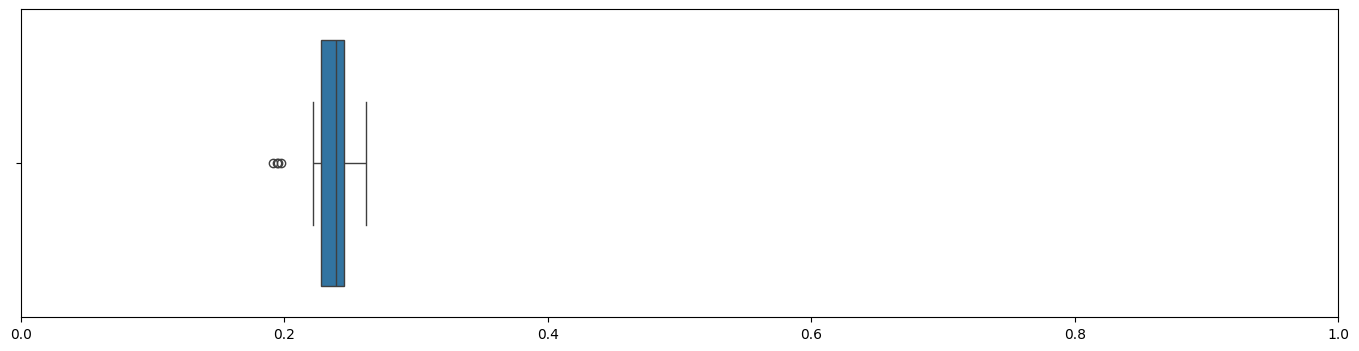

In [25]:
plt.figure(figsize=(17, 4))
sns.boxplot(kendalls, orient="h")
plt.xlim(0, 1)

### PCA

#### PCA on methods

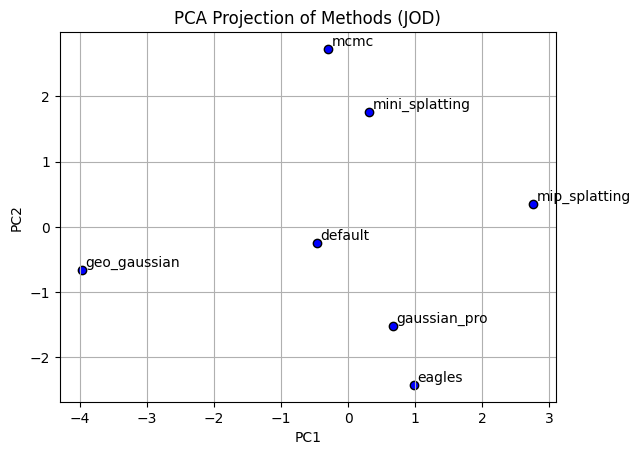

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def pca_project_jod_methods(ax: plt.Axes) -> None:
    data = (
        df_jod_cv_20.groupby(["dataset", "size"]).mean().iloc[:,2:]
    )
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.transpose())

    # Apply PCA
    pca = PCA(n_components=2)  # Keep all components
    pca.fit(data_scaled)

    data_pca = pca.transform(data_scaled)

    ax.scatter(data_pca[:, 0], data_pca[:, 1], c="b", edgecolors="k")
    for i, method in enumerate(data.columns):
        ax.annotate(method, (data_pca[i, 0] + 0.05, data_pca[i, 1] + 0.05))
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"PCA Projection of Methods (JOD)")
    ax.grid()

fig, ax = plt.subplots(1, 1)
pca_project_methods(ax)

#### PCA on facets

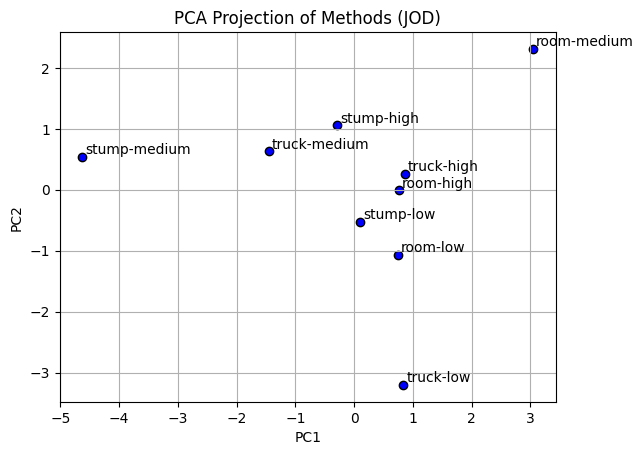

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def pca_project_jod_facets(ax: plt.Axes) -> None:
    data = (
        df_jod_cv_20.groupby(["dataset", "size"]).mean().iloc[:,2:]
    )
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # Apply PCA
    pca = PCA(n_components=2)  # Keep all components
    pca.fit(data_scaled)

    data_pca = pca.transform(data_scaled)

    ax.scatter(data_pca[:, 0], data_pca[:, 1], c="b", edgecolors="k")
    for i, (dataset, size) in enumerate(data.index):
        ax.annotate(f"{dataset}-{size}", (data_pca[i, 0] + 0.05, data_pca[i, 1] + 0.05))
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_title(f"PCA Projection of Methods (JOD)")
    ax.grid()

fig, ax = plt.subplots(1, 1)
pca_project_jod_facets(ax)

## Correlation Analysis

So given my JOD values, what kind of correlation could I even compute?

For each facet of my data I can create scatterplot where one observation is a method.

### Scatterplots - facet by facet

In [26]:
from typing import Dict
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, norm, spearmanr
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


def compute_linear_rmse(x, y) -> float:
    X = x.values.reshape(-1, 1)  # Reshape for sklearn
    y = y.values

    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)
    rmse_linear = np.sqrt(mean_squared_error(y, y_pred_linear))
    return rmse_linear


def compute_nonlinear_rmse(x, y) -> float:
    X = x.values.reshape(-1, 1)  # Reshape for sklearn
    y = y.values

    # Nonlinear (Quadratic) Regression
    X_nonlinear = np.column_stack((X, X**2))  # Add x^2 term
    nonlinear_model = (
        LinearRegression()
    )  # Still use linear regression, but with transformed features
    nonlinear_model.fit(X_nonlinear, y)
    y_pred_nonlinear = nonlinear_model.predict(X_nonlinear)
    rmse_nonlinear = np.sqrt(mean_squared_error(y, y_pred_nonlinear))
    return rmse_nonlinear


def compute_spearman(x, y) -> float:
    corr, _ = spearmanr(x, y)
    return corr


def compute_pearsonr(x, y) -> float:
    corr, _ = pearsonr(x, y)
    return corr


def plot_quality_metric_against_jod_by_facet(quality_metric: str = "psnr") -> None:
    fig, axs = plt.subplots(3, 3)

    for i, dataset in enumerate(df_metrics["dataset"].unique()):
        for j, size in enumerate(["low", "medium", "high"]):
            single_facet_df = join_quality_metrics_by_facet(
                quality_metric, dataset, size
            )
            axs[i][j].scatter(single_facet_df["jod"], single_facet_df[quality_metric])

    fig.suptitle(quality_metric)
    plt.show()


def plot_quality_metric_against_jod(quality_metric: str = "psnr") -> None:
    df = join_quality_metrics(quality_metric)
    plt.scatter(df["jod"], df[quality_metric])

    plt.suptitle(quality_metric)
    plt.show()


def join_quality_metrics(quality_metric: str) -> pd.DataFrame:
    df_jod_agg = df_jod.melt(
        id_vars=["dataset", "size"],
        value_vars=[
            "default",
            "mcmc",
            "mini_splatting",
            "eagles",
            "mip_splatting",
            "gaussian_pro",
            "geo_gaussian",
        ],
    ).rename({"variable": "model", "value": "jod"}, axis=1)
    df_jod_agg["model"] = df_jod_agg["model"].apply(lambda x: x.replace("_", "-"))
    df_jod_agg = df_jod_agg.set_index(["model", "dataset", "size"])
    df_metrics_agg = df_metrics.groupby(["model", "dataset", "size"])[
        [quality_metric]
    ].mean()
    return df_jod_agg.join(df_metrics_agg)


def join_quality_metrics_by_facet(
    quality_metric: str, dataset: str, size: str
) -> pd.DataFrame:
    single_facet_df = (
        df_jod[(df_jod["dataset"] == dataset) & (df_jod["size"] == size)]
        .transpose()
        .iloc[3:]
        .rename(lambda x: "jod", axis=1)
    )
    metrics_df = aggregate_metrics_by_facet(df_metrics, quality_metric, dataset, size)
    single_facet_df = single_facet_df.join(metrics_df)
    return single_facet_df


def create_correlation_dataframe_by_facet(quality_metric: str = "psnr") -> pd.DataFrame:
    records = []
    for dataset in df_metrics["dataset"].unique():
        for size in ["low", "medium", "high"]:
            single_facet_df = join_quality_metrics_by_facet(
                quality_metric, dataset, size
            )
            records.append(
                create_record(quality_metric, single_facet_df, dataset, size)
            )
    return pd.DataFrame.from_records(records)


def create_record(
    quality_metric: str,
    df: pd.DataFrame,
    dataset: str = None,
    size: str = None,
) -> Dict:
    record = {
        "SROCC": compute_spearman(df["jod"], df[quality_metric]),
        "PLCC": compute_pearsonr(
            df["jod"].astype(np.float32),
            df[quality_metric].astype(np.float32),
        ),
        "RMSE_lin": compute_linear_rmse(
            df["jod"],
            df[quality_metric],
        ),
        "RMSE_cub": compute_nonlinear_rmse(
            df["jod"],
            df[quality_metric],
        ),
    }

    if dataset is not None:
        record["dataset"] = dataset
    if size is not None:
        record["size"] = size

    return record


def aggregate_metrics(quality_metric: str) -> pd.DataFrame:
    if quality_metric == "brisque":
        metric_single_facet = (
            df_metrics.melt(
                id_vars=["model", "dataset", "size", "view_idx"],
                value_vars=[
                    "brisque",
                    "brisque_0",
                    "brisque_1",
                    "brisque_2",
                    "brisque_3",
                    "brisque_4",
                ],
            )
            .groupby(["model", "dataset", "size"])["value"]
            .mean()
        )
    else:
        metric_single_facet = df_metrics.groupby(["model", "dataset", "size"])[
            quality_metric
        ].mean()
    metrics_df = pd.DataFrame.from_dict(
        {
            "technique": [
                technique.replace("-", "_")
                for technique, _, _ in metric_single_facet.index
            ],
            quality_metric: metric_single_facet.values,
        }
    ).set_index("technique")

    return metrics_df


def aggregate_metrics_by_facet(
    df: pd.DataFrame, quality_metric: str, dataset: str, size: str
) -> pd.DataFrame:
    if quality_metric == "brisque":
        metric_single_facet = (
            df[(df["dataset"] == dataset) & (df["size"] == size)]
            .melt(
                id_vars=["model", "dataset", "size", "view_idx"],
                value_vars=[
                    "brisque",
                    "brisque_0",
                    "brisque_1",
                    "brisque_2",
                    "brisque_3",
                    "brisque_4",
                ],
            )
            .groupby(["model", "dataset", "size"])["value"]
            .mean()
        )
    else:
        metric_single_facet = (
            df[(df["dataset"] == dataset) & (df["size"] == size)]
            .groupby(["model", "dataset", "size"])[quality_metric]
            .mean()
        )
    metrics_df = pd.DataFrame.from_dict(
        {
            "technique": [
                technique.replace("-", "_")
                for technique, _, _ in metric_single_facet.index
            ],
            quality_metric: metric_single_facet.values,
        }
    ).set_index("technique")

    return metrics_df

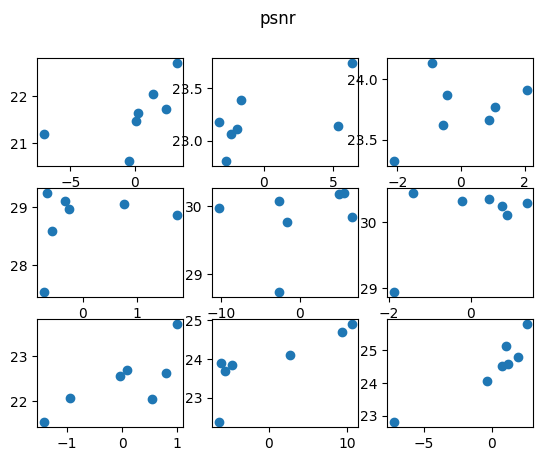

In [27]:
plot_quality_metric_against_jod_by_facet()
df_psnr = create_correlation_dataframe_by_facet()

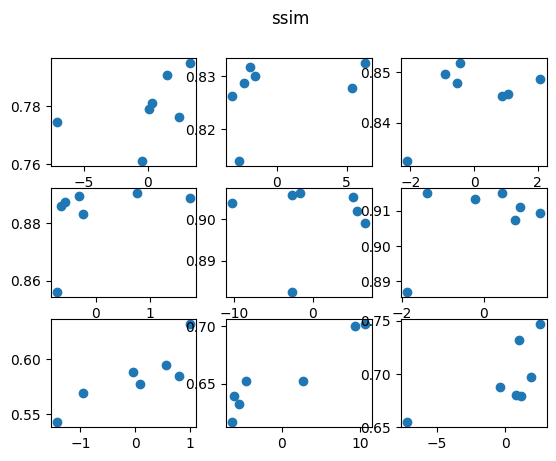

In [28]:
plot_quality_metric_against_jod_by_facet("ssim")
df_ssim = create_correlation_dataframe_by_facet("ssim")

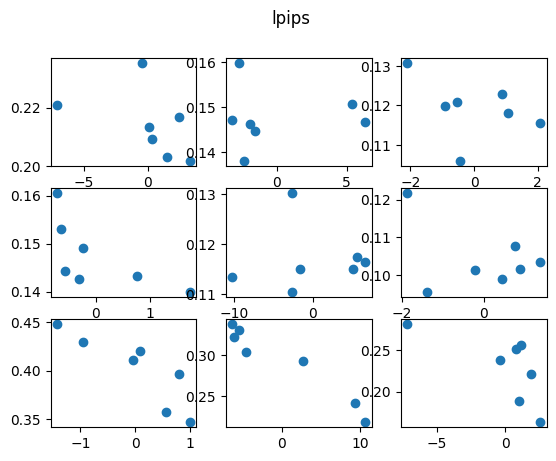

In [29]:
plot_quality_metric_against_jod_by_facet("lpips")
df_lpips = create_correlation_dataframe_by_facet("lpips")

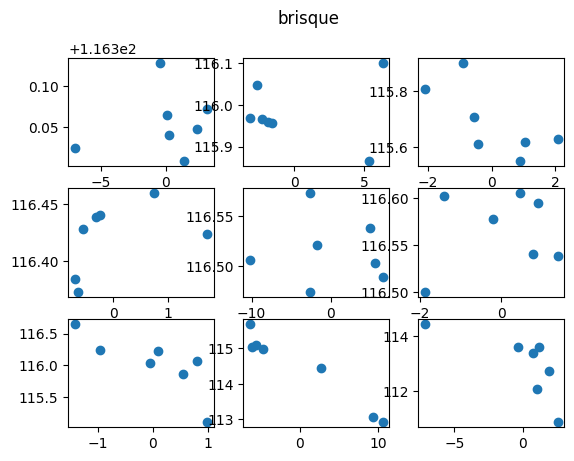

In [30]:
plot_quality_metric_against_jod_by_facet("brisque")
df_brisque = create_correlation_dataframe_by_facet("brisque")

### Heatmap - Facet by Facet

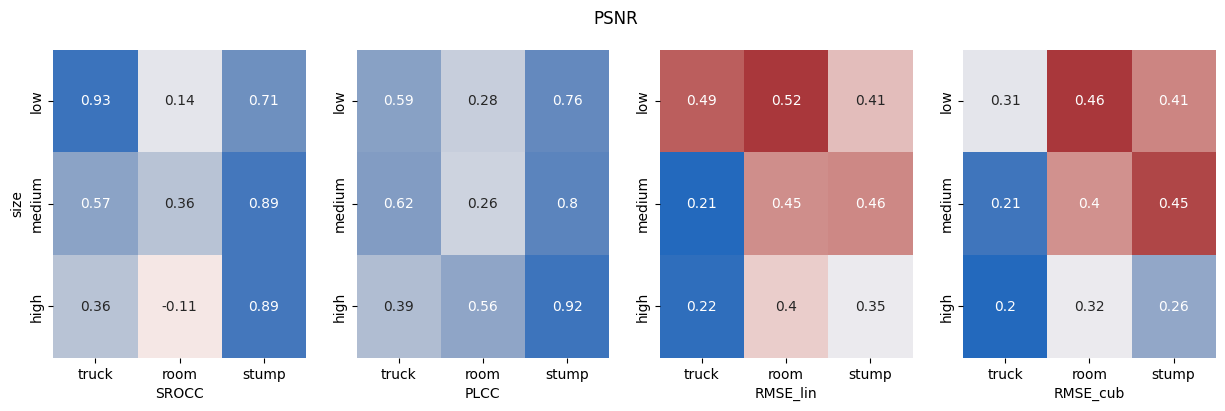

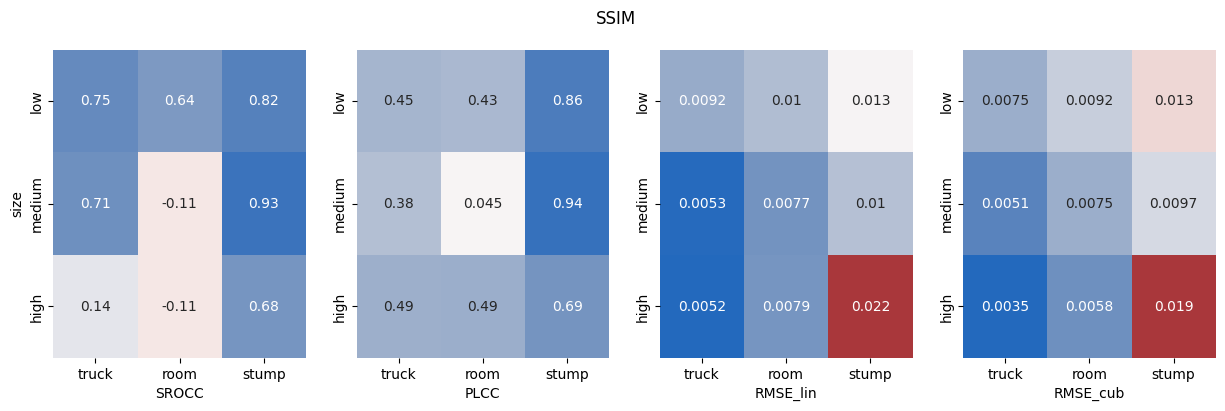

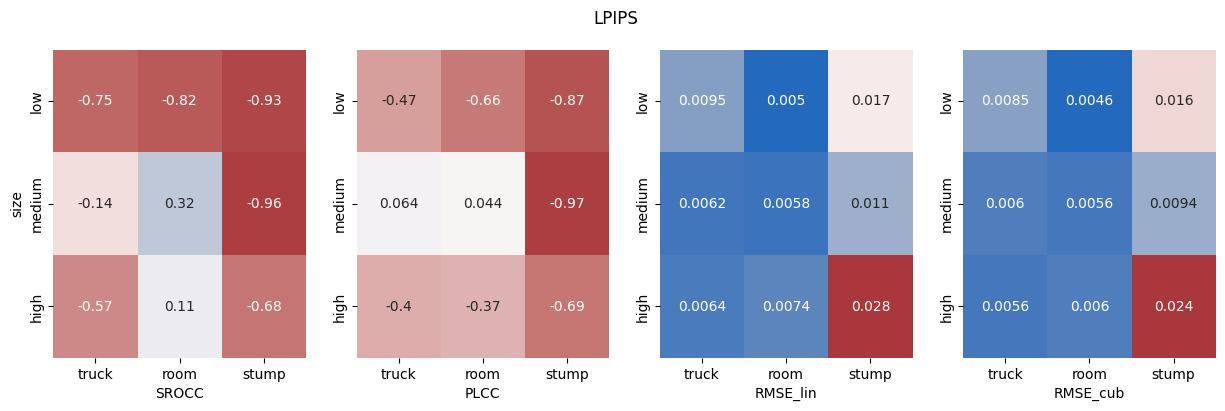

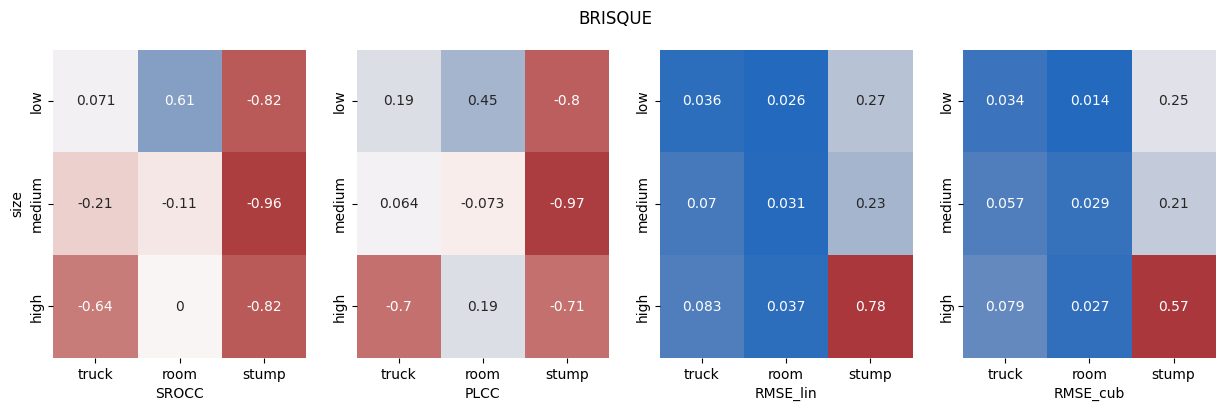

In [31]:
import seaborn as sns


def plot_heatmap_for_metrics(dataframe: pd.DataFrame, title: str):
    metrics = ["SROCC", "PLCC", "RMSE_lin", "RMSE_cub"]

    fig, axs = plt.subplots(1, len(metrics), figsize=(15, 4))

    for i, metric in enumerate(metrics):
        df_pivot = dataframe[[metric, "size", "dataset"]]
        df_pivot = pd.pivot(
            df_pivot, columns=["dataset"], index=["size"], values=[metric]
        )
        df_pivot.columns = df_pivot.columns.map(lambda x: x[1])
        df_pivot.index = pd.CategoricalIndex(
            df_pivot.index, categories=["low", "medium", "high"], ordered=True
        )
        df_pivot.sort_index(inplace=True)
        cmap = sns.color_palette("vlag", as_cmap=True).reversed()
        if "RMSE" in metric:
           cmap = cmap.reversed()
        sns.heatmap(
            df_pivot[["truck", "room", "stump"]],
            annot=True,
            ax=axs[i],
            cbar=False,
            cmap=cmap,
            vmin=None if "RMSE" in metric else -1,
            vmax=None if "RMSE" in metric else 1,
        )
        axs[i].set_xlabel(metric)
        if i > 0:
            axs[i].set_ylabel("")

    fig.suptitle(title)
    plt.show()


plot_heatmap_for_metrics(df_psnr, "PSNR")
plot_heatmap_for_metrics(df_ssim, "SSIM")
plot_heatmap_for_metrics(df_lpips, "LPIPS")
plot_heatmap_for_metrics(df_brisque, "BRISQUE")

### Scatterplot - Correlation/ No facets

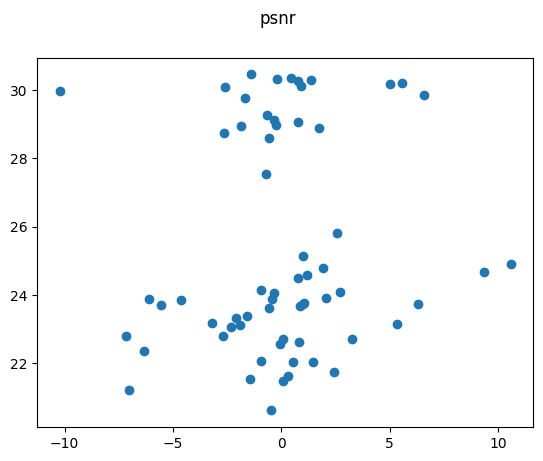

In [32]:
plot_quality_metric_against_jod("psnr")

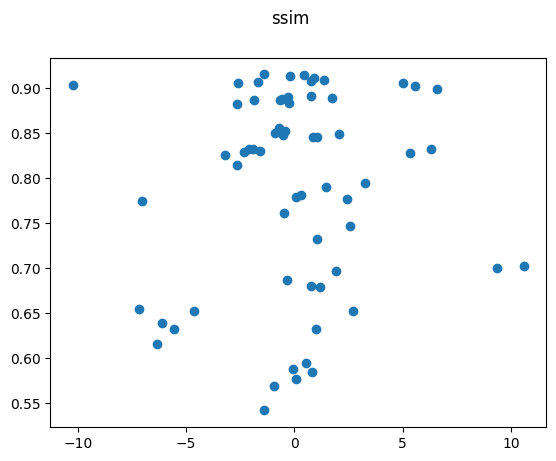

In [33]:
plot_quality_metric_against_jod("ssim")

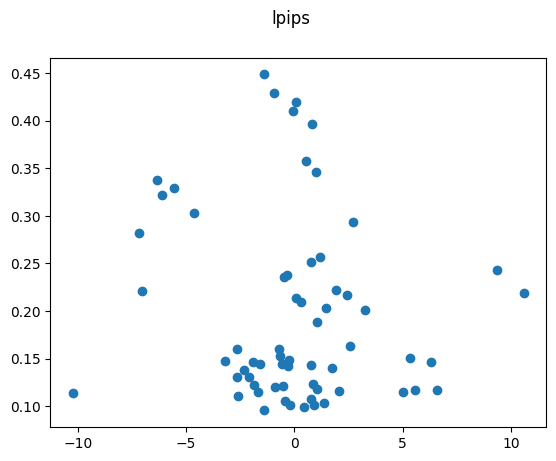

In [34]:
plot_quality_metric_against_jod("lpips")

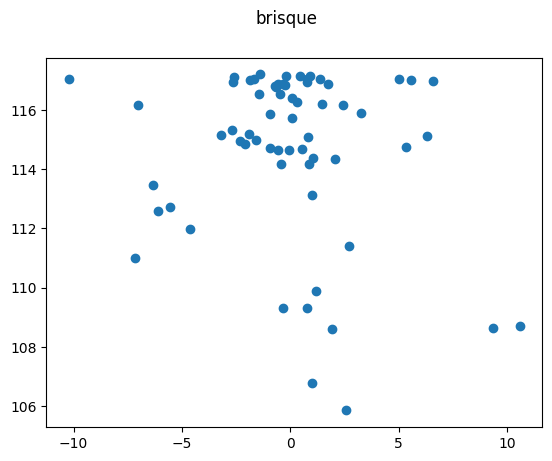

In [35]:
plot_quality_metric_against_jod("brisque")

### Cross Validation

In [36]:
jod_cv_10 = pd.read_excel("data/jod_k_fold_10.xlsx")

### Facet Correlation CV

In [37]:
from sklearn.model_selection import KFold


def compute_cv_correlation_analysis(jod_cv_df: pd.DataFrame) -> pd.DataFrame:
    K = jod_cv_df["fold_idx"].max() + 1

    records = []

    for dataset in ["room", "stump", "truck"]:
        for size in ["low", "medium", "high"]:
            for quality_metric in ["psnr", "ssim", "lpips", "brisque"]:
                kf = KFold(n_splits=K, shuffle=True, random_state=42)

                facet_metrics = df_metrics[
                    (df_metrics["size"] == size) & (df_metrics["dataset"] == dataset)
                ]
                for fold_idx, (train_idx, test_idx) in enumerate(kf.split(facet_metrics)):
                    fold_metrics = facet_metrics.iloc[train_idx]
                    fold_jod = jod_cv_df[
                        (jod_cv_df["dataset"] == dataset)
                        & (jod_cv_df["size"] == size)
                        & (jod_cv_df["fold_idx"] == fold_idx)
                    ]
                    df_agg_metrics = aggregate_metrics_by_facet(
                        facet_metrics, quality_metric, dataset, size
                    )
                    df_agg_metrics = df_agg_metrics.join(
                        fold_jod.transpose().iloc[4:].rename(lambda x: "jod", axis=1)
                    )
                    records.append(
                        {
                            "metric": quality_metric,
                            "dataset": dataset,
                            "size": size,
                            "fold_idx": fold_idx,
                            "SROCC": compute_spearman(
                                df_agg_metrics["jod"], df_agg_metrics[quality_metric]
                            ),
                            "PLCC": compute_pearsonr(
                                df_agg_metrics["jod"].astype(np.float32),
                                df_agg_metrics[quality_metric].astype(np.float32),
                            ),
                        }
                    )
    return pd.DataFrame.from_records(records)


df_cv_10 = compute_cv_correlation_analysis(jod_cv_10)

In [174]:
import seaborn as sns


def plot_cv_results(
    df_cv: pd.DataFrame,
    corr_measure: str = "PLCC",
    metric: str = "psnr",
    ax: plt.Axes = None,
) -> None:
    K = df_cv["fold_idx"].max() + 1
    df_cv_plot = df_cv.copy()[df_cv["metric"] == metric]
    df_cv_plot["facet"] = df_cv_plot[["dataset", "size"]].apply(
        lambda row: f"{row.iloc[0]}-{row.iloc[1]}", axis=1
    )

    if ax is None:
        plt.figure(figsize=(7, 5))
    sns.violinplot(df_cv_plot, x="facet", y=corr_measure, hue="dataset", ax=ax)
    if ax is None:
        plt.suptitle(
            f"Correlation ({corr_measure}) {K}-Fold CV - JOD vs. {metric.upper()}"
        )
        plt.xticks(rotation=90)
        plt.show()
    else:
        ax.set_title(
            f"Correlation ({corr_measure}) {K}-Fold CV - JOD vs. {metric.upper()}"
        )
        ax.set_xticks(ax.get_xticks(), ["low", "medium", "high"] * 3)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_xlabel("")
        ax.grid(axis="y")
        ax.set_axisbelow(True)

#### Violinplots - 10 Fold CV

In [175]:
def plot_cv_results_full(df_cv: pd.DataFrame) -> None:
    fig, axs = plt.subplots(4, 2, figsize=(14, 20))
    for idx_c, corr_measure in enumerate(["PLCC", "SROCC"]):
        for idx_m, metric in enumerate(["ssim", "psnr", "lpips", "brisque"]):
            plot_cv_results(df_cv, corr_measure, metric, ax=axs[idx_m][idx_c])
    plt.tight_layout()
    plt.show()

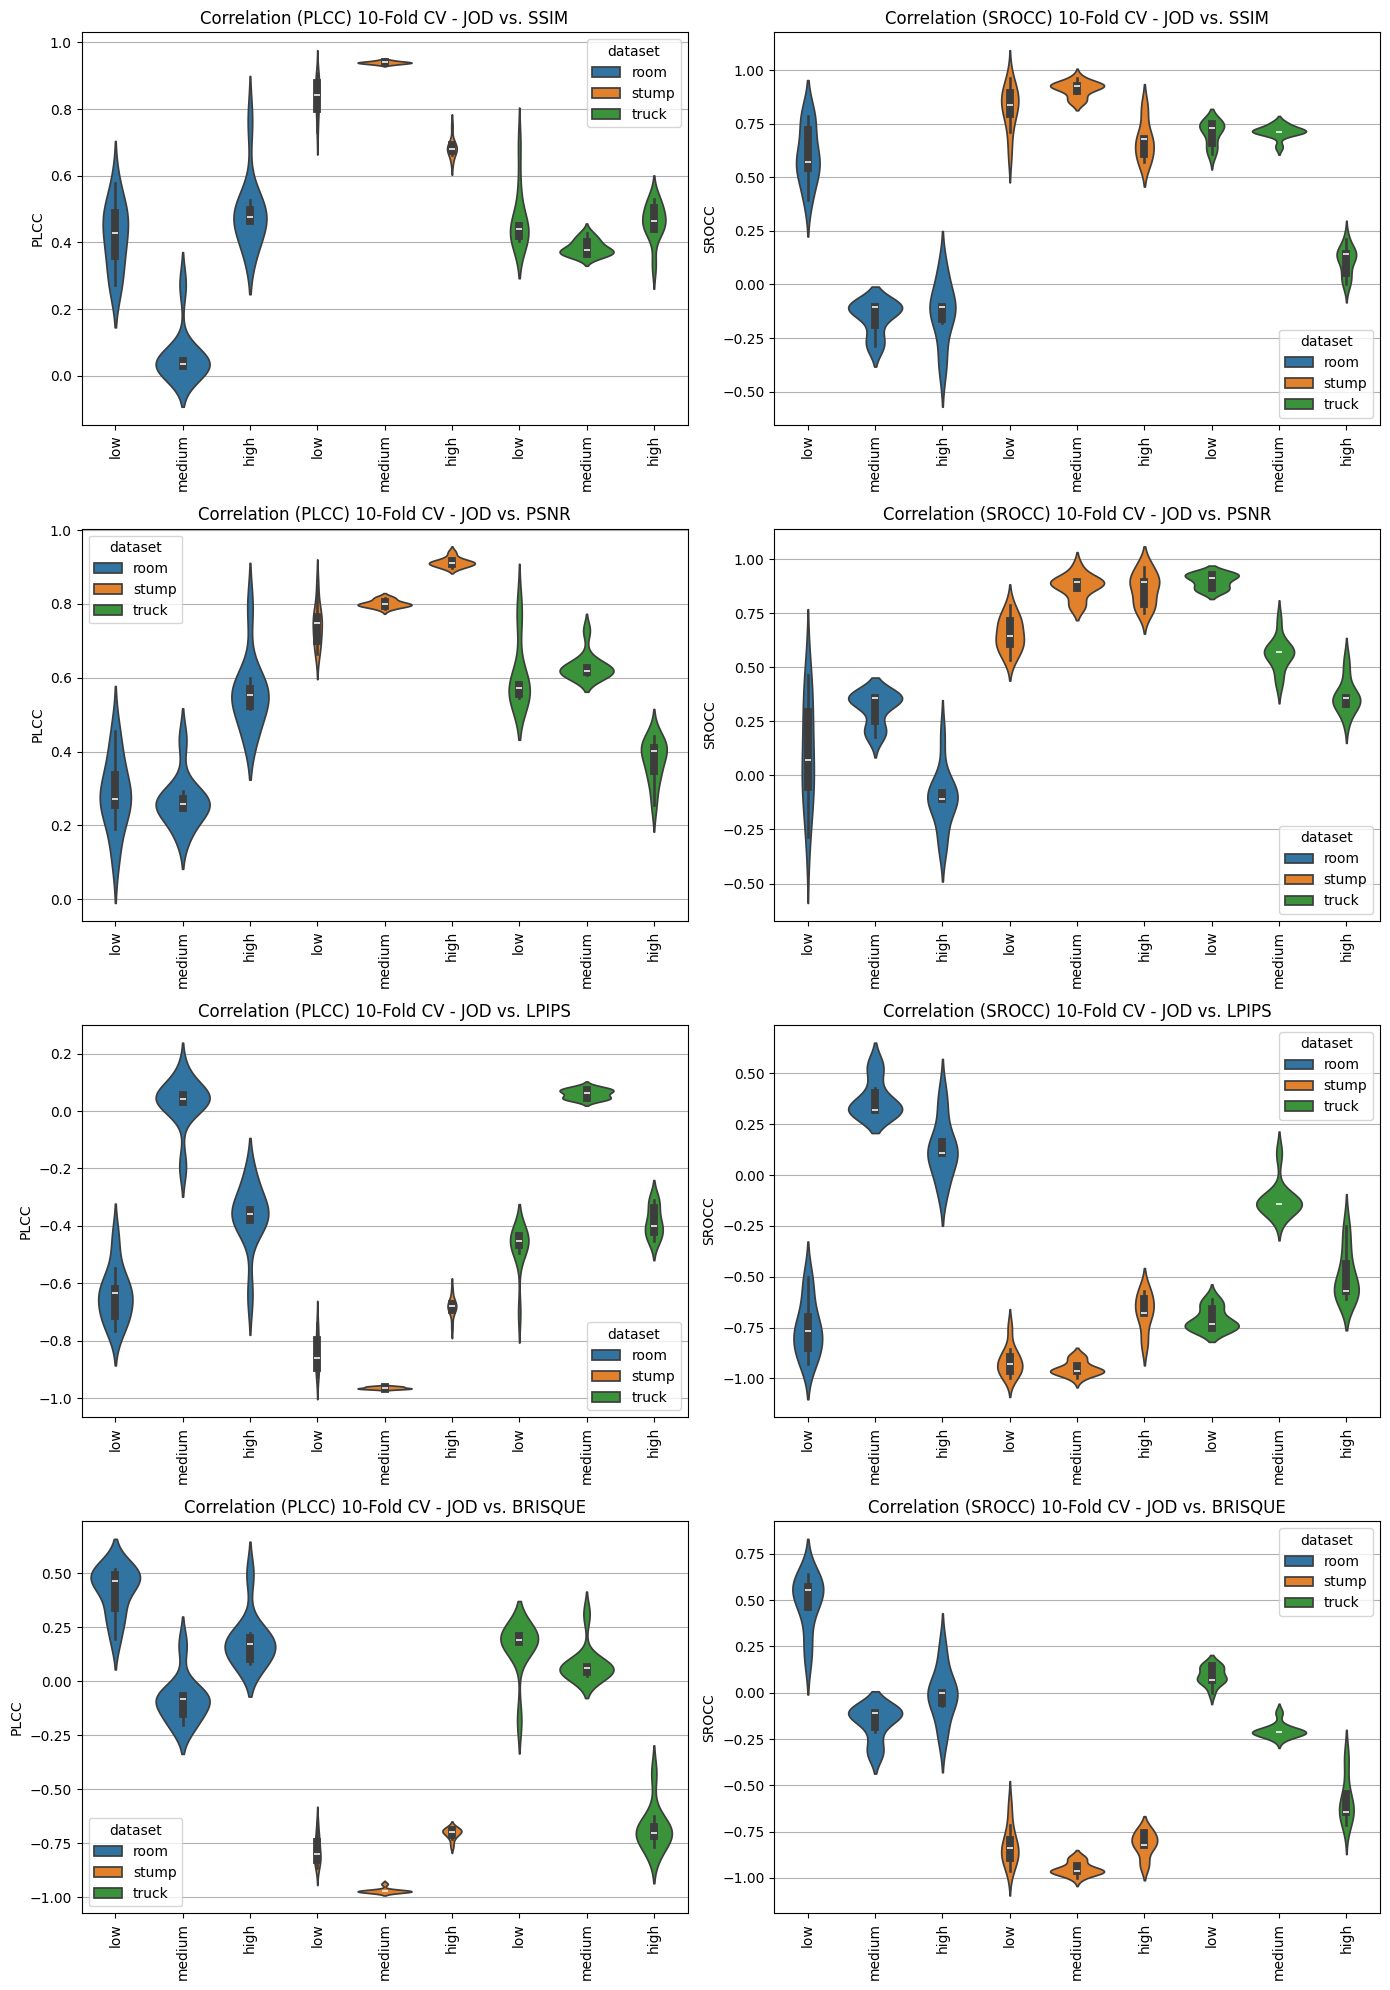

In [176]:
plot_cv_results_full(df_cv_10)

#### Violinplots - 20 Fold CV

In [177]:
jod_cv_20 = pd.read_excel("data/jod_k_fold_20.xlsx")
df_cv_20 = compute_cv_correlation_analysis(jod_cv_20)

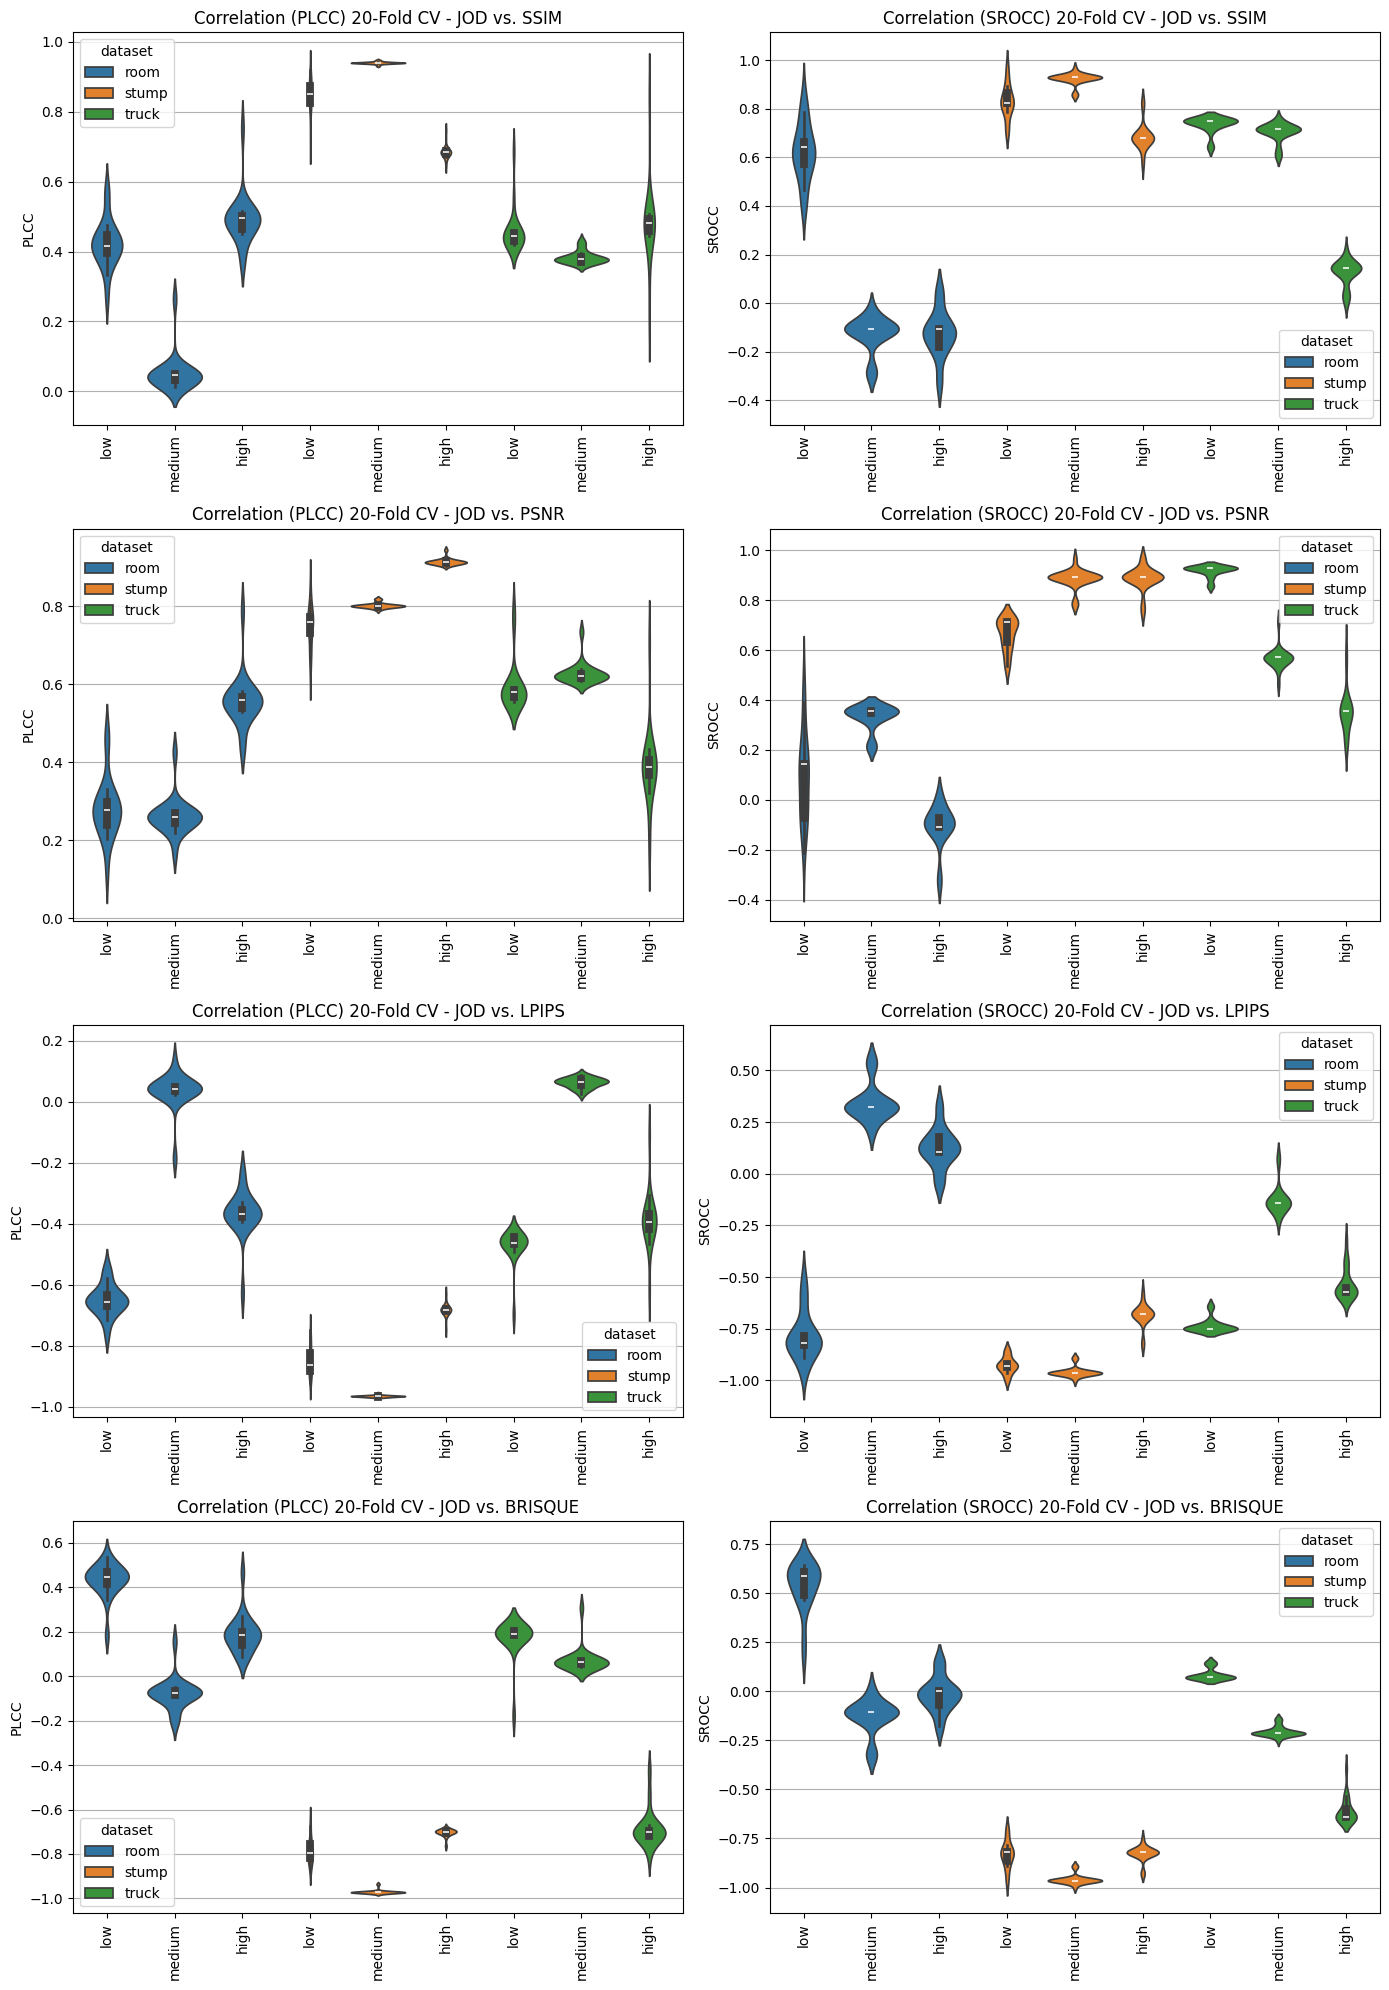

In [178]:
plot_cv_results_full(df_cv_20)

### Method Correlation CV

In [88]:
df_metrics

,Unnamed: 0,model,dataset,size,view_idx,psnr,ssim,lpips,brisque,brisque_0,brisque_1,brisque_2,brisque_3,brisque_4
0,0,default,truck,low,0,22.854264,0.790509,0.226080,115.171706,116.365727,116.175164,116.571363,116.465530,116.870682
1,1,default,truck,low,1,22.087402,0.785129,0.229505,115.159007,116.353566,116.561380,116.115368,116.371243,116.572193
2,2,default,truck,low,2,20.998178,0.745329,0.237442,115.215300,116.132138,117.636262,116.601709,116.134324,116.476936
3,3,default,truck,low,3,22.493696,0.799899,0.165673,116.010326,116.095639,116.190634,116.396090,116.385333,116.126286
4,4,default,truck,low,4,23.064885,0.815660,0.170480,116.741971,116.263953,116.116958,116.151579,116.576700,116.825905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,1822,mip-splatting,stump,high,11,26.102052,0.743161,0.182536,105.694250,105.093251,116.546228,107.029798,104.232949,116.918969
1823,1823,mip-splatting,stump,high,12,26.311424,0.789606,0.148852,101.186885,116.735507,117.200589,109.614684,108.231041,112.686759
1824,1824,mip-splatting,stump,high,13,25.426722,0.721831,0.187944,104.223245,117.109026,116.652989,118.302471,116.627304,106.532821
1825,1825,mip-splatting,stump,high,14,26.387055,0.786564,0.147307,101.425684,107.237983,105.066702,114.810484,114.733411,116.091095


In [89]:
df_jod_cv_20

,Unnamed: 0,size,dataset,fold_idx,default,mcmc,mini_splatting,eagles,mip_splatting,gaussian_pro,geo_gaussian
0,0,low,room,0,1.889599,-0.641652,-0.747568,-0.384492,1.225611,-0.598738,-0.742762
1,1,low,room,1,6.410905,-0.724706,-1.700299,-1.280626,-0.279626,-1.016188,-1.409475
2,2,low,room,2,1.692514,-0.041335,-0.633308,-0.540559,0.658998,-0.445071,-0.691242
3,3,low,room,3,1.681915,-0.237478,-0.644640,-0.559102,0.751033,-0.312601,-0.679129
4,4,low,room,4,1.652473,-0.229456,-0.643158,-0.547514,0.670736,-0.313977,-0.589104
...,...,...,...,...,...,...,...,...,...,...,...
175,175,high,truck,15,-0.536126,-0.902467,-0.505849,2.041196,0.843753,1.029916,-1.970423
176,176,high,truck,16,-0.536126,-0.902467,-0.505849,2.041196,0.843753,1.029916,-1.970423
177,177,high,truck,17,-0.527973,-0.672681,-0.620896,2.020922,0.825211,1.014218,-2.038803
178,178,high,truck,18,-0.679229,-0.895150,-0.426064,2.047629,0.868893,1.044147,-1.960229


In [132]:
from sklearn.model_selection import KFold


def compute_cv_correlation_analysis_method(jod_cv_df: pd.DataFrame) -> pd.DataFrame:
    K = jod_cv_df["fold_idx"].max() + 1

    records = []

    for method in df_metrics["model"].unique():
        for quality_metric in ["psnr", "ssim", "lpips", "brisque"]:
            kf = KFold(n_splits=K, shuffle=True, random_state=42)

            method_metrics = df_metrics[(df_metrics["model"] == method)]
            for fold_idx, (train_idx, test_idx) in enumerate(kf.split(method_metrics)):
                if quality_metric == "brisque":
                    fold_metrics = (
                        method_metrics.iloc[train_idx]
                        .melt(
                            id_vars=["dataset", "size"],
                            value_vars=[
                                "brisque",
                                "brisque_0",
                                "brisque_1",
                                "brisque_2",
                                "brisque_3",
                                "brisque_4",
                            ],
                        )
                        .groupby(["dataset", "size"])[["value"]]
                        .mean()
                        .rename(lambda _: "brisque", axis=1)
                    )
                else:
                    fold_metrics = (
                        method_metrics.iloc[train_idx]
                        .groupby(["dataset", "size"])[quality_metric]
                        .mean()
                    )
                fold_jod = (
                    jod_cv_df[jod_cv_df["fold_idx"] == fold_idx][
                        ["dataset", "size", method.replace("-", "_")]
                    ]
                    .set_index(["dataset", "size"])
                    .rename(lambda _: "jod", axis=1)
                )
                joined_fold = fold_jod.join(fold_metrics)

                records.append(
                    {
                        "metric": quality_metric,
                        "method": method,
                        "fold_idx": fold_idx,
                        "SROCC": compute_spearman(
                            joined_fold["jod"], joined_fold[quality_metric]
                        ),
                        "PLCC": compute_pearsonr(
                            joined_fold["jod"].astype(np.float32),
                            joined_fold[quality_metric].astype(np.float32),
                        ),
                    }
                )
    return pd.DataFrame.from_records(records)

#### Violinplot - 10 Fold CV

In [133]:
df_method_cv_10 = compute_cv_correlation_analysis_method(jod_cv_10)

In [170]:
def plot_method_corr_violin(
    df_cv: pd.DataFrame, metric: str, corr_measure: str, ax: plt.Axes
) -> None:
    df_constrained = df_cv[df_cv["metric"] == metric]
    K = int(df_constrained.shape[0] / 7)
    sns.violinplot(
        df_constrained,
        x="method",
        y=corr_measure,
        order=df_constrained.groupby("method")[corr_measure]
        .mean()
        .sort_values(ascending=False)
        .index,
        hue_order=[
            "mcmc",
            "mini-splatting",
            "gaussian-pro",
            "mip-splatting",
            "eagles",
            "default",
            "geo-gaussian",
        ],
        hue="method",
        ax=ax,
    )
    ax.set_title(f"Correlation ({corr_measure}) {K}-Fold CV - JOD vs. {metric.upper()}")
    ax.tick_params(labelrotation=90)
    ax.grid(axis='y')
    ax.set_axisbelow(True)

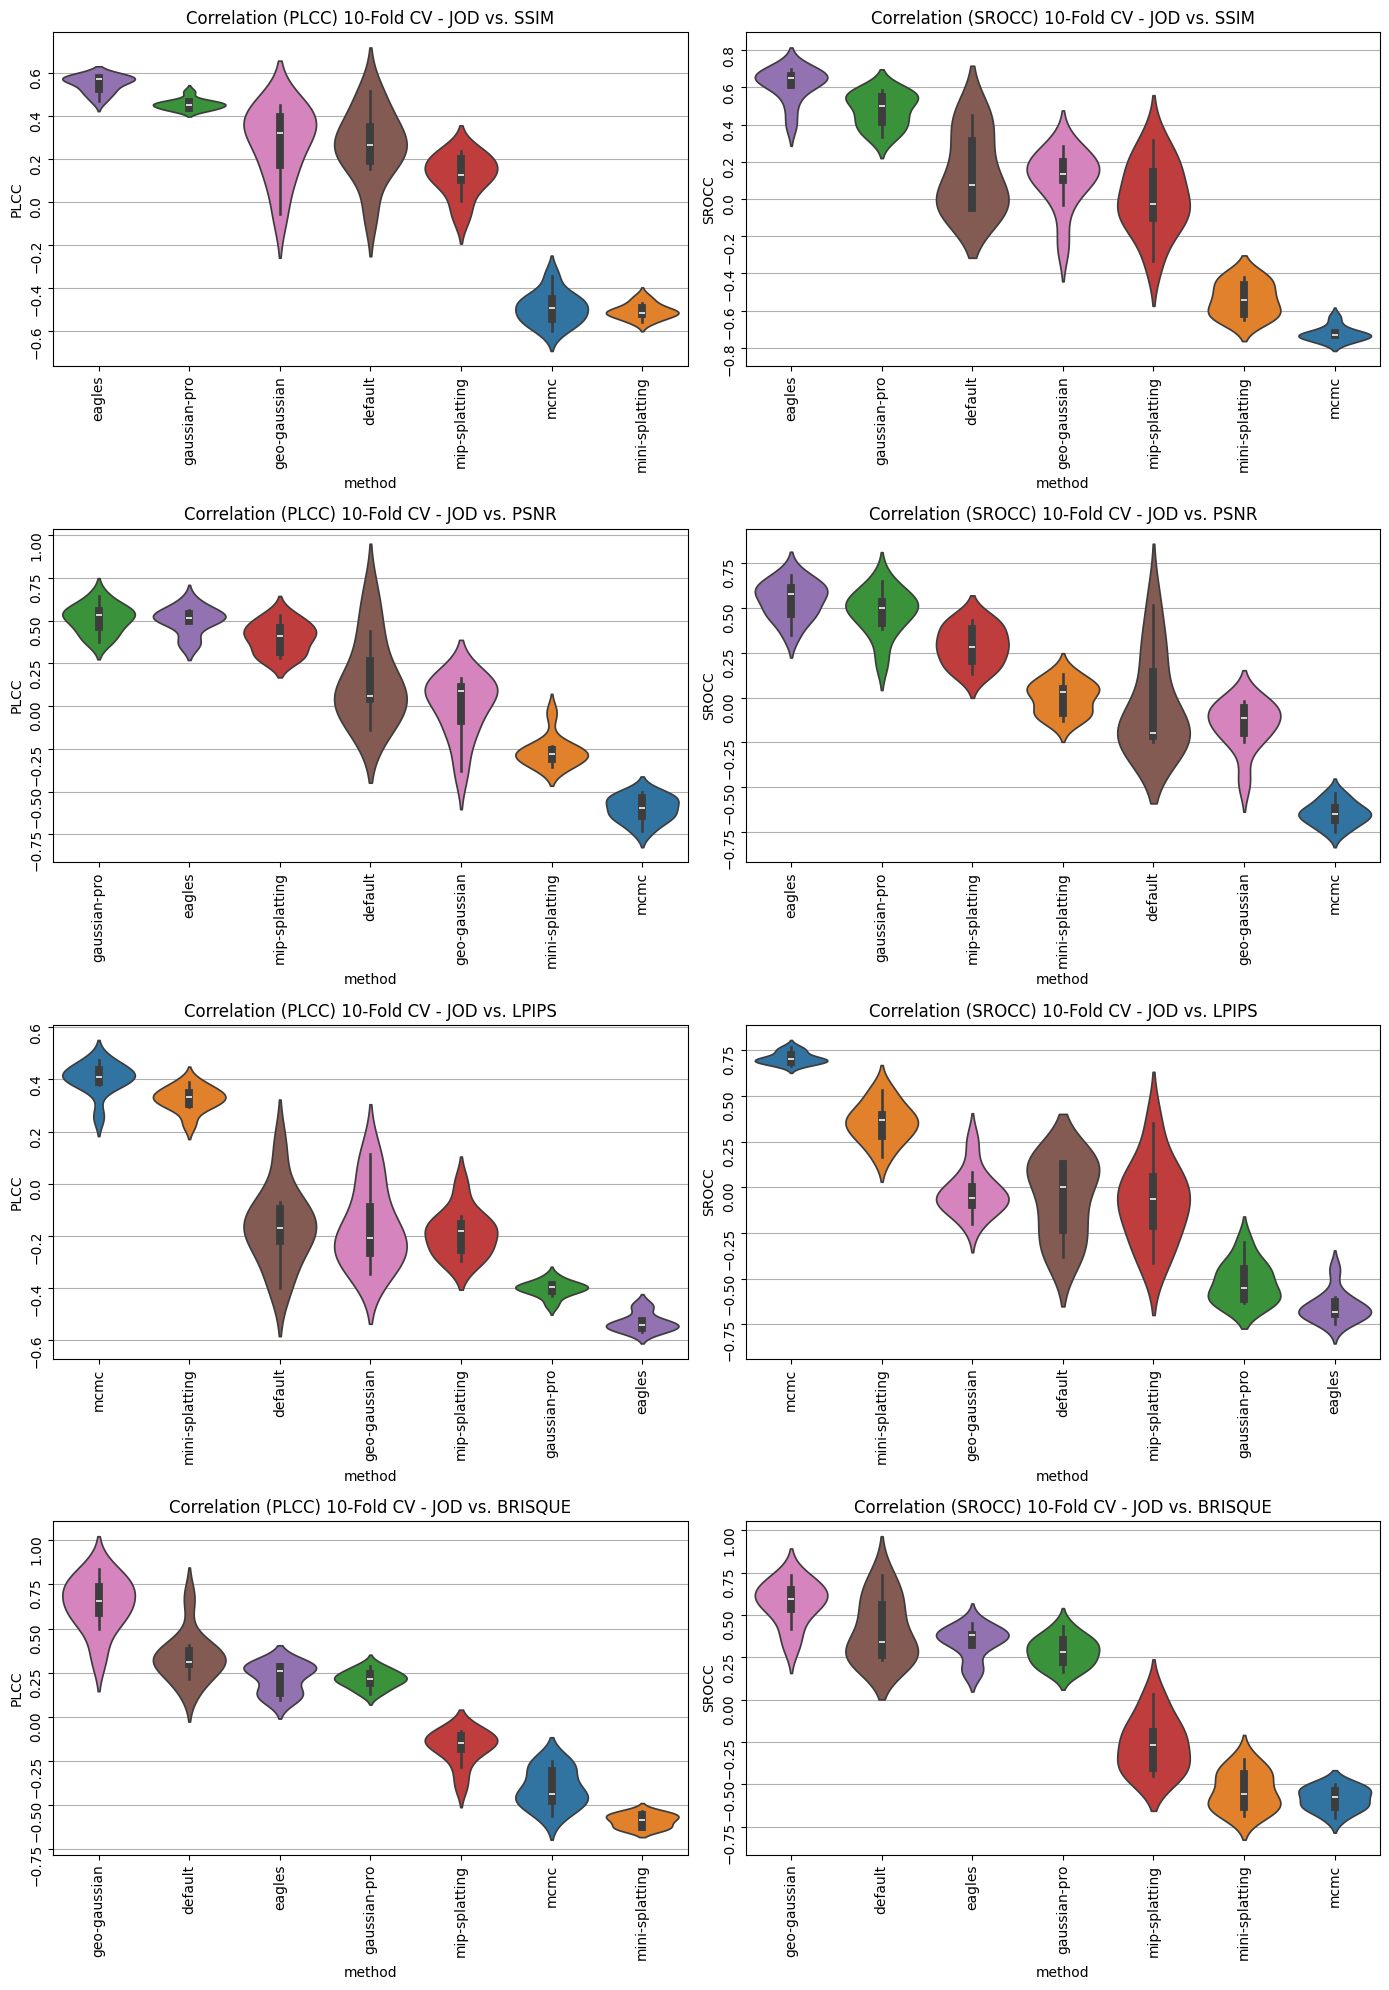

In [171]:
fig, axs = plt.subplots(4, 2, figsize=(14, 20))

for idx_c, corr_measure in enumerate(["PLCC", "SROCC"]):
    for idx_m, metric in enumerate(["ssim", "psnr", "lpips", "brisque"]):
        plot_method_corr_violin(
            df_method_cv_10, metric, corr_measure, axs[idx_m][idx_c]
        )
plt.tight_layout()
plt.show()

#### Violinplot - 20 Fold CV

In [172]:
df_method_cv_20 = compute_cv_correlation_analysis_method(jod_cv_20)

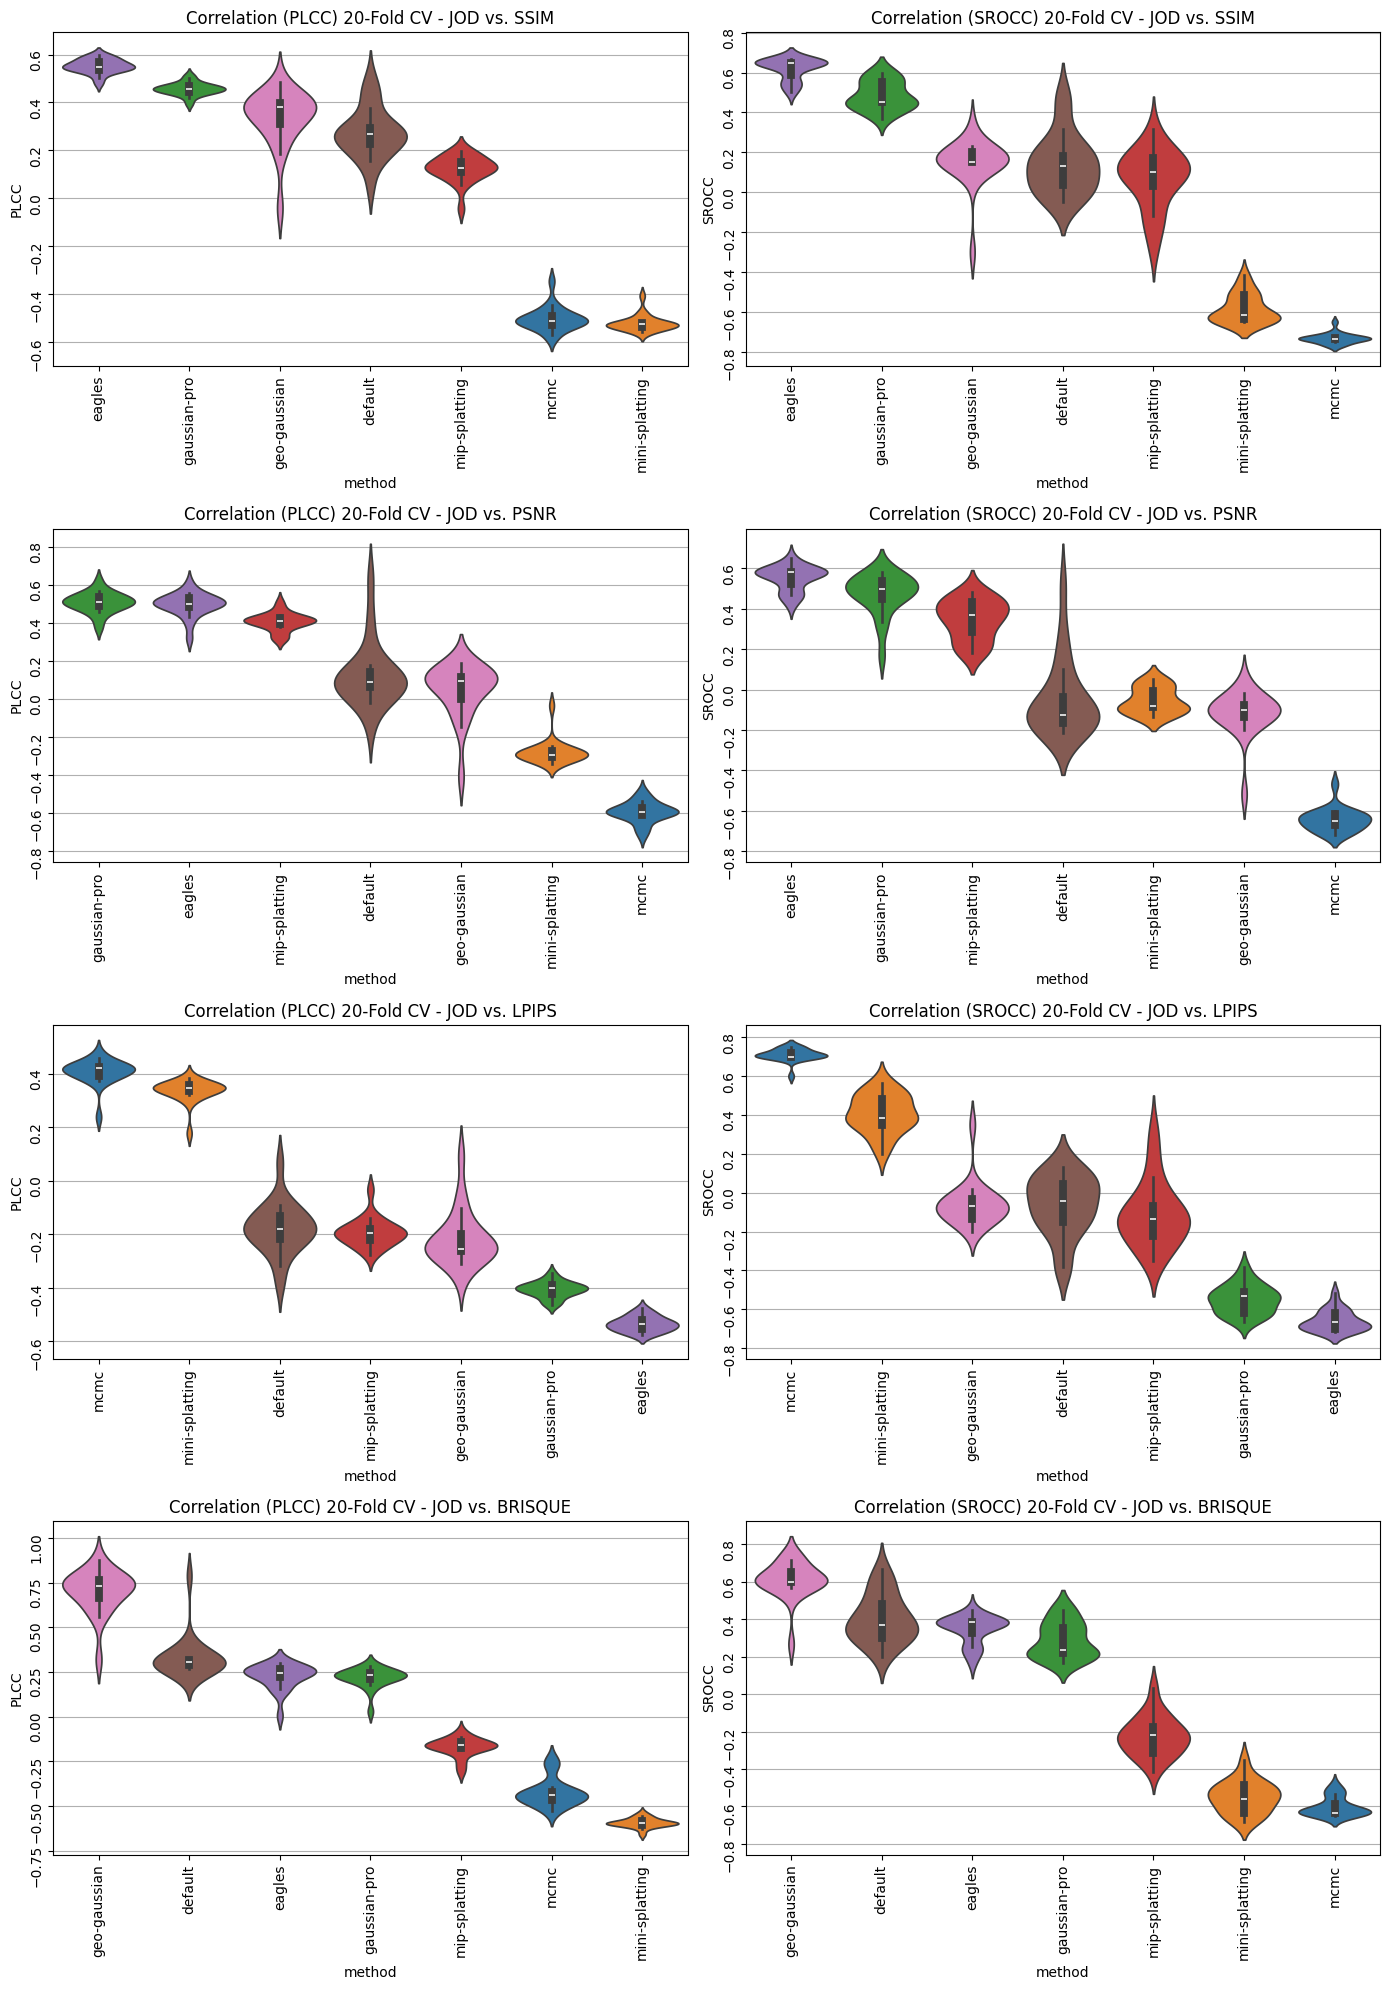

In [173]:
fig, axs = plt.subplots(4, 2, figsize=(14, 20))

for idx_c, corr_measure in enumerate(["PLCC", "SROCC"]):
    for idx_m, metric in enumerate(["ssim", "psnr", "lpips", "brisque"]):
        plot_method_corr_violin(
            df_method_cv_20, metric, corr_measure, axs[idx_m][idx_c]
        )
plt.tight_layout()
plt.show()

### Violinplot - JOD Variability

In [43]:
jod_cv_20

,Unnamed: 0,size,dataset,fold_idx,default,mcmc,mini_splatting,eagles,mip_splatting,gaussian_pro,geo_gaussian
0,0,low,room,0,1.889599,-0.641652,-0.747568,-0.384492,1.225611,-0.598738,-0.742762
1,1,low,room,1,6.410905,-0.724706,-1.700299,-1.280626,-0.279626,-1.016188,-1.409475
2,2,low,room,2,1.692514,-0.041335,-0.633308,-0.540559,0.658998,-0.445071,-0.691242
3,3,low,room,3,1.681915,-0.237478,-0.644640,-0.559102,0.751033,-0.312601,-0.679129
4,4,low,room,4,1.652473,-0.229456,-0.643158,-0.547514,0.670736,-0.313977,-0.589104
...,...,...,...,...,...,...,...,...,...,...,...
175,175,high,truck,15,-0.536126,-0.902467,-0.505849,2.041196,0.843753,1.029916,-1.970423
176,176,high,truck,16,-0.536126,-0.902467,-0.505849,2.041196,0.843753,1.029916,-1.970423
177,177,high,truck,17,-0.527973,-0.672681,-0.620896,2.020922,0.825211,1.014218,-2.038803
178,178,high,truck,18,-0.679229,-0.895150,-0.426064,2.047629,0.868893,1.044147,-1.960229


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'room-low'),
  Text(1, 0, 'room-medium'),
  Text(2, 0, 'room-high'),
  Text(3, 0, 'stump-low'),
  Text(4, 0, 'stump-medium'),
  Text(5, 0, 'stump-high'),
  Text(6, 0, 'truck-low'),
  Text(7, 0, 'truck-medium'),
  Text(8, 0, 'truck-high')])

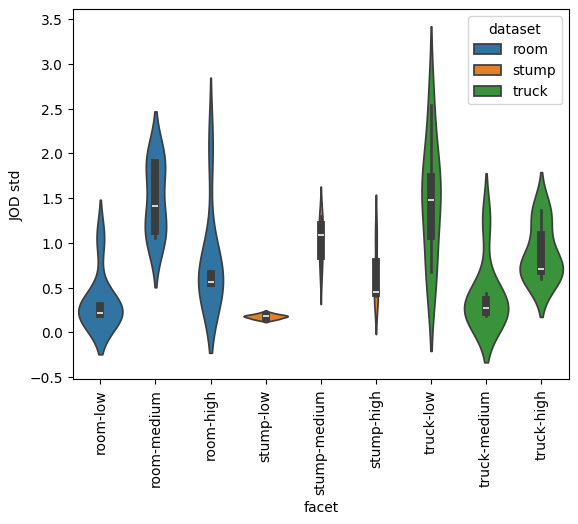

In [44]:
jod_cv_20_facet = jod_cv_20.copy()
jod_cv_20_facet["facet"] = jod_cv_20_facet[["dataset", "size"]].apply(
    lambda row: f"{row.iloc[0]}-{row.iloc[1]}", axis=1
)
jod_cv_20_facet = (
    (jod_cv_20_facet.iloc[:, 4:].groupby(["facet"]).std())
    .reset_index()
    .melt(id_vars="facet")
    .rename({"value": "JOD std"}, axis=1)
)
jod_cv_20_facet
jod_cv_20_facet["dataset"] = jod_cv_20_facet["facet"].apply(lambda x: x.split("-")[0])
jod_cv_20_facet["size"] = jod_cv_20_facet["facet"].apply(lambda x: x.split("-")[1])


def get_key(x):
    idx = {"low": 0, "medium": 1, "high": 2}
    return f"{x.split('-')[0]}-{idx[x.split('-')[1]]}"


jod_cv_20_facet = jod_cv_20_facet.sort_values("facet", key=np.vectorize(get_key))

sns.violinplot(jod_cv_20_facet, x="facet", y="JOD std", hue="dataset")
plt.xticks(rotation=90)

### Boxplot - JOD variability

/tmp/ipykernel_8934/2623664365.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: f"{x[0]}-{x[1]}", axis=1


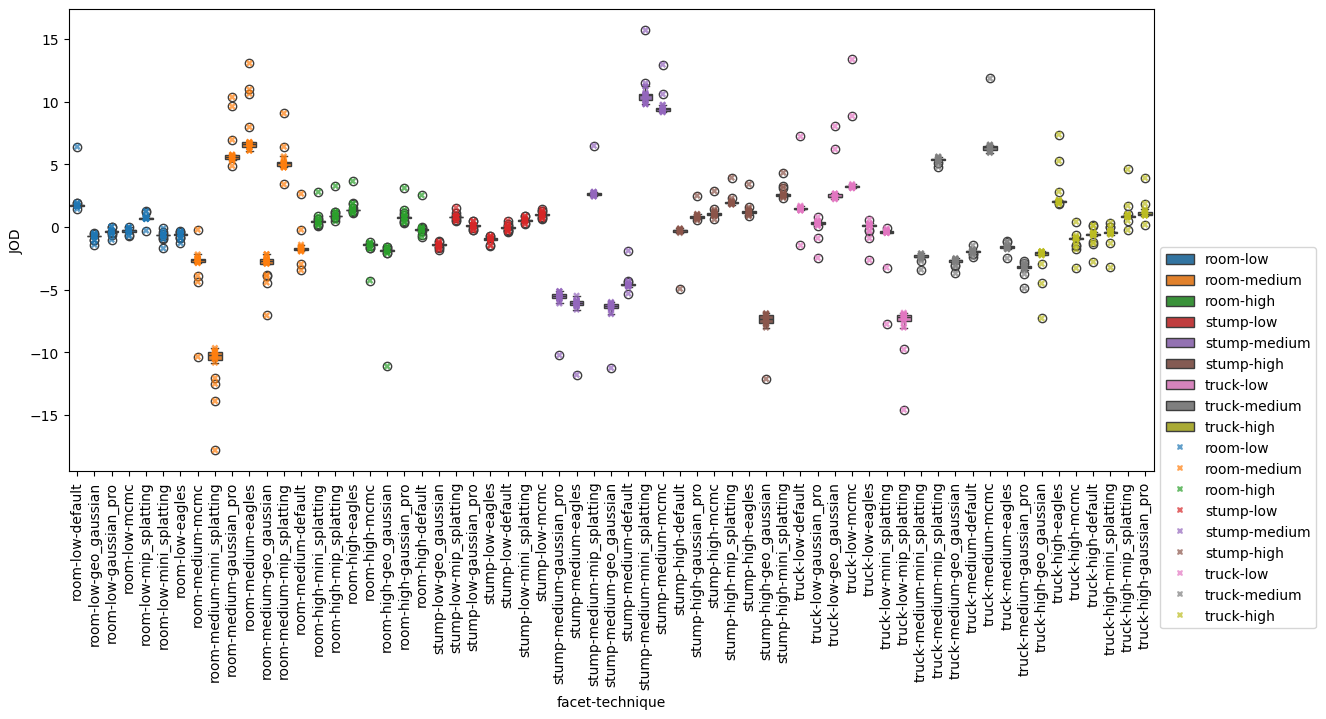

In [45]:
jod_cv_20_facet = jod_cv_20.copy()
jod_cv_20_facet["facet"] = jod_cv_20_facet[["dataset", "size"]].apply(
    lambda row: f"{row.iloc[0]}-{row.iloc[1]}", axis=1
)
jod_cv_20_facet = (
    (jod_cv_20_facet.iloc[:, 4:])
    .melt(id_vars="facet")
    .rename({"value": "JOD", "variable": "technique"}, axis=1)
)
jod_cv_20_facet["dataset"] = jod_cv_20_facet["facet"].apply(lambda x: x.split("-")[0])
jod_cv_20_facet["size"] = jod_cv_20_facet["facet"].apply(lambda x: x.split("-")[1])
jod_cv_20_facet["facet-technique"] = jod_cv_20_facet[["facet", "technique"]].apply(
    lambda x: f"{x[0]}-{x[1]}", axis=1
)
jod_cv_20_facet


def get_key(x):
    idx = {"low": 0, "medium": 1, "high": 2}
    return f"{x.split('-')[0]}-{idx[x.split('-')[1]]}"


jod_cv_20_facet = jod_cv_20_facet.sort_values("facet", key=np.vectorize(get_key))

plt.figure(figsize=(14, 6))
ax = sns.boxplot(jod_cv_20_facet, x="facet-technique", y="JOD", hue="facet")
sns.stripplot(
    jod_cv_20_facet,
    x="facet-technique",
    y="JOD",
    hue="facet",
    marker="X",
    jitter=False,
    alpha=0.7,
)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.0, 0.5))
plt.show()

### Congruence between wandb and cluster test measurements

In [46]:
df_wand_test = pd.read_parquet("./data/test_statistics.parquet")
df_wand_test

,test_full/ssim,test_full/psnr,dataset_name,technique,size
0,0.596729,15.807237,truck,mcmc,low
1,0.676081,19.094009,truck,mcmc,low
2,0.676081,19.094009,truck,mcmc,low
3,0.701434,20.109855,truck,mcmc,low
4,0.712163,20.520590,truck,mcmc,low
...,...,...,...,...,...
85,0.680591,23.276541,stump,geo_gaussian,high
86,0.680591,23.276541,stump,geo_gaussian,high
87,0.679724,23.223272,stump,geo_gaussian,high
88,0.680399,23.259621,stump,geo_gaussian,high


In [47]:
def compute_cluster_and_wandb_congruency() -> pd.DataFrame:
    records = []
    for size in df_wand_test["size"].unique():
        for technique in df_wand_test["technique"].unique():
            for dataset in df_wand_test["dataset_name"].unique():
                wand_observation = df_wand_test[
                    (df_wand_test["_step"] == 30000)
                    & (df_wand_test["dataset_name"] == dataset)
                    & (df_wand_test["technique"] == technique)
                    & (df_wand_test["size"] == size)
                ]
                assert len(wand_observation) == 1, wand_observation.shape
                cluster_observation = df_metrics[
                    (df_metrics["dataset"] == dataset)
                    & (df_metrics["model"] == technique.replace("_", "-"))
                    & (df_metrics["size"] == size)
                ]
                records.append({
                    "technique": technique,
                    "dataset": dataset,
                    "size": size,
                    "diff_psnr": wand_observation["test_full/psnr"].iloc[-1] - cluster_observation["psnr"].mean(),
                    "diff_ssim": wand_observation["test_full/ssim"].iloc[-1] - cluster_observation["ssim"].mean(),
                    "name": f"{technique}-{dataset}-{size}"
                })
    
    return pd.DataFrame.from_records(records)

In [48]:
incongruency = compute_cluster_and_wandb_congruency()
incongruency

KeyError: '_step'

In [ ]:
plt.figure(figsize=(12,5))
sns.barplot(incongruency, x="name", y="diff_psnr")
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize=(12,5))
sns.barplot(incongruency, x="name", y="diff_ssim")
plt.xticks(rotation=90)
plt.show()

### How consistent is the ranking across my two different data sources?

In [ ]:
def compute_cluster_and_wandb_rank_consistency() -> pd.DataFrame:
    records = []
    for size in df_wand_test["size"].unique():
        for dataset in df_wand_test["dataset_name"].unique():
            wand_observations = df_wand_test[
                (df_wand_test["_step"] == 30000)
                & (df_wand_test["dataset_name"] == dataset)
                & (df_wand_test["size"] == size)
            ].set_index("technique")
            assert len(wand_observations) == 7, wand_observations.shape
            cluster_observations = (
                df_metrics[
                    (df_metrics["dataset"] == dataset) & (df_metrics["size"] == size)
                ]
                .groupby("model")[["psnr", "ssim"]]
                .mean()
            )
            assert len(cluster_observations) == 7, wand_observations.shape

            record = {
                "dataset": dataset,
                "size": size,
            }
            for var_name_wand, var_name_metrics in [
                ("test_full/ssim", "ssim"),
                ("test_full/psnr", "psnr"),
            ]:
                rank_diff = wand_observations[
                    var_name_wand
                ].rank().sort_index() - cluster_observations[
                    var_name_metrics
                ].rank().sort_index().rename(
                    index=lambda x: x.replace("-", "_")
                )
                record[f"{var_name_metrics}_methods"] = (rank_diff[rank_diff != 0].index.values)
                record[f"absolute_rank_diff_{var_name_metrics}"] = rank_diff.abs().sum()

            records.append(record)

    return pd.DataFrame.from_records(records)


compute_cluster_and_wandb_rank_consistency().sort_values("absolute_rank_diff_psnr")